In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# import custom modules
sys.path.append('../scripts')
import funcs

---
---
# Table of contents
* [1. Load source data](#load-data)
    * [1.1. Preview headers](#preview-headers)  
* [2. Prepare data headers](#prep-headers)
    * [2.1. Preview headers, descriptions, and units](#view-headers)
    * [2.2. Clean headers, descriptions, and units](#clean-headers)
        * [2.2.1. Units (multi-header index 2)](#units)
        * [2.2.2. Descriptions (multi-header index 1)](#descriptions)
        * [2.2.3. Variables (multi-header index 0)](#variables)
        * [2.2.4. Data values](#data-vals)
* [3. Standardize data headers](#standardizing-steps)
    * [3.1. Copy of filename_headers to filename_headers_lookup](#copy)
    * [3.2. Assign lookup table header names](#assign)
    * [3.3. Use ESS-Dive leaf-gas-exchange standards to create lookup table](#multiheader-standards)
    * [3.4. Load the lookup table](#complete-lookup)
    * [3.5. Use the lookup table to standardize headers](#standardize)
* [4. Data quality control](#qc)
    * [4.1. Strings](#strings)
    * [4.2. Measurememt device](#device)
    * [4.3. Season](#season)
    * [4.4. Plant height](#height)
    * [4.5. Datetimes](#datetimes)
    * [4.6. Species names](#species)
    * [4.7. Create species lookup table](#species-lookup)
    * [4.8. Fill in species lookup table](#fill-species-lookup)
        * [4.8.1. Format headers](#species-lookup-headers)
        * [4.8.2. Merge lookup table with data](#merge)
        * [4.8.3. Drop extra columns](#drop)
* [5. Data unit conversion](#unit-conversion)
    * [5.1. Visualize and confirm unit conversions](#confirm-conversion)
    * [5.2. Drop out-of-range (oor) values](#oor)

---
---
## 1. Load the data <a class="anchor" id="load-data"></a>

In [2]:
# ensure source file is in UTF-8 format
filename = 'lin_2015'
data_path = f'../data/input/{filename}/WUEdatabase_2015-11-20_All_opt_full_params_bitbucket.csv'
utf8_data_path = funcs.convert_to_utf8sig(data_path)
metadata_path = f'../data/input/{filename}/WUEmetadata.csv'
utf8_metadata_path = funcs.convert_to_utf8sig(metadata_path)

Encoding utf-8 was detected for ../data/input/lin_2015/WUEdatabase_2015-11-20_All_opt_full_params_bitbucket.csv.
Converted ../data/input/lin_2015/WUEdatabase_2015-11-20_All_opt_full_params_bitbucket.csv to utf-8-sig and saved as ../data/input/lin_2015/WUEdatabase_2015-11-20_All_opt_full_params_bitbucket_utf8sig.csv
Encoding ascii was detected for ../data/input/lin_2015/WUEmetadata.csv.
Converted ../data/input/lin_2015/WUEmetadata.csv to utf-8-sig and saved as ../data/input/lin_2015/WUEmetadata_utf8sig.csv


In [3]:
# import LCE site data
data = pd.read_csv(data_path, na_values=[-9999, '-9999'], encoding='utf-8-sig')
metadata = pd.read_csv(metadata_path, delimiter='|', skiprows=[1], encoding='utf-8-sig')

# I found later that the strings in metadata have a ton of extra whitespace
metadata = metadata.map(lambda x: x.strip() if isinstance(x, str) else x)

---
### 1.1. Preview the data and metadata headers <a class="anchor" id="preview-headers"></a>
If there are no metadata provided, you must create a metadata .csv based on the headers in the data

In [4]:
# data headers
data.columns

Index(['Pathway', 'Type', 'Plantform', 'Leafspan', 'Tregion', 'Wregion',
       'Wregion2', 'opt', 'Date', 'Time', 'Datacontrib', 'Species', 'Funtype',
       'fitgroup', 'Location', 'RH', 'Tair', 'Tleaf', 'CO2S', 'PARin', 'Patm',
       'BLCond', 'Trmmol', 'SWC', 'SWP', 'latitude', 'longitude',
       'Totalheight', 'LAI', 'sampleheight', 'canopyposition', 'LWP',
       'LWPpredawn', 'Instrument', 'Season', 'GrowthCa', 'GrowthTair',
       'Growthcond', 'Treatment', 'OriginalFile', 'Comments', 'Reference',
       'LightSource', 'Cond', 'Photo', 'VPD', 'Ci'],
      dtype='object')

In [5]:
# Show current columns
metadata.columns

Index(['variable ', ' description ', ' unit'], dtype='object')

In [6]:
# this is how the metadata file should be structured before reading it: variable, description, units
# this may have to be created or edited manually before reading it here
metadata = metadata.rename(columns={'variable ':'variable', 
                                    ' unit':'unit', 
                                    ' description ':'description'})
metadata

,variable,description,unit
0,Pathway,Photosynthetic pathway,"C3, C4, CAM"
1,Type,Gymnosperm or angiosperm,"'gymnosperm', 'angiosperm'"
2,Plantform,Plant life form,"'tree', 'shrub', 'grass', 'crop', 'savanna'"
3,Leafspan,Evergreen or Deciduous,"'evergreen', 'deciduous'"
4,Tregion,Biome,"'arctic', 'boreal', 'temperate', 'tropical'"
...,...,...,...
56,LeafNum,Leaf number,(string)
57,OriginalFile,Original file name from data contributor,(string)
58,Comments,Anything useful related to the data,(string)
59,Reference,Referee associated with the data set,(string)


---
---
## 2. Prepare data headers <a class="anchor" id="prep-headers"></a>
Add variable/description/units to as a 3-row multi-header

In [7]:
# merge metadata with data column names
columns_df = pd.DataFrame({'variable': data.columns})
matched_metadata = columns_df.merge(metadata, on='variable', how='left')

# check for unmatched variables
unmatched = matched_metadata[matched_metadata['description'].isnull()]
if not unmatched.empty:
    print("Warning: Some columns in the data file do not match the metadata:")
    print(unmatched)

In [8]:
# drop unmatched variables
matched_metadata = matched_metadata.dropna(subset=['variable'])
data = data[matched_metadata['variable'].tolist()]

# create the description and unit rows
description_row = matched_metadata['description'].tolist()
unit_row = matched_metadata['unit'].tolist()
data_with_metadata = pd.concat(
    [pd.DataFrame([description_row, unit_row], columns=data.columns), data],
    ignore_index=True)

# Set the multi-index
data_with_metadata.columns = pd.MultiIndex.from_arrays(
    [data.columns, description_row, unit_row],
    names=['variable', 'description', 'unit'])
data_with_metadata = data_with_metadata.iloc[2:]

In [9]:
# replace data dataframe with the one with metadata
data = data_with_metadata.iloc[2:].copy()
data

variable,Pathway,Type,Plantform,Leafspan,Tregion,Wregion,Wregion2,opt,Date,Time,...,Growthcond,Treatment,OriginalFile,Comments,Reference,LightSource,Cond,Photo,VPD,Ci
description,Photosynthetic pathway,Gymnosperm or angiosperm,Plant life form,Evergreen or Deciduous,Biome,Classification based on aridity index,Moisture index,Growing under ambient or stressed condition,Date of the year when measurement conducted,Time of the day when measurement conducted,...,Growth condition,Experimental treatment,Original file name from data contributor,Anything useful related to the data,Referee associated with the data set,Light source used in the cuvette,Stomatal conductance,Photosynthetic rate,Vapour pressure deficit,Intercelllular [CO2]
unit,"C3, C4, CAM","'gymnosperm', 'angiosperm'","'tree', 'shrub', 'grass', 'crop', 'savanna'","'evergreen', 'deciduous'","'arctic', 'boreal', 'temperate', 'tropical'","'arid', 'semi-arid', 'dry sub-humid', 'humid'",(numerical),'opt' or 'non-opt',,,...,"'Glasshouse', ' Field', 'Potted plant', 'Whole-tree chamber', etc.","'fertilization', 'irrigation', etc.",(string),(string),(string),(string),mol m-2 s-1,umol m-2 s-1,kPa,ppm
4,C3,angiosperm,shrub,deciduous,Arctic,dry sub-humid,0.546,opt,20130719,18:13:21,...,field,none,JY19_Jorge_Survey,spot measurements at ambient,Rogers unpublished,NaN,0.354783,7.150692,0.391062,353.200784
5,C3,angiosperm,shrub,deciduous,Arctic,dry sub-humid,0.546,opt,20130719,18:57:39,...,field,none,JY19_Jorge_Survey,spot measurements at ambient,Rogers unpublished,NaN,0.314206,10.371518,0.417362,330.23055
6,C3,angiosperm,shrub,deciduous,Arctic,dry sub-humid,0.546,opt,20130719,18:32:02,...,field,none,JY19_Jorge_Survey,spot measurements at ambient,Rogers unpublished,NaN,0.285865,11.385411,0.430059,317.419211
7,C3,angiosperm,shrub,deciduous,Arctic,dry sub-humid,0.546,opt,20130719,18:43:23,...,field,none,JY19_Jorge_Survey,spot measurements at ambient,Rogers unpublished,NaN,0.248947,9.091525,0.43252,323.695808
8,C3,angiosperm,shrub,deciduous,Arctic,dry sub-humid,0.546,opt,20130719,17:47:13,...,field,none,JY19_Jorge_Survey,spot measurements at ambient,Rogers unpublished,NaN,0.232038,11.31974,0.404308,303.947063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15159,C3,angiosperm,tree,deciduous,temperate,humid,1.055,opt,31-Aug,14:14,...,field,none,none,Automated branch cuvette,Linderson et al_2012_AFM,none,0.305936,9.4,0.693283,254.1
15160,C3,angiosperm,tree,deciduous,temperate,humid,1.055,opt,31-Aug,14:18,...,field,none,none,Automated branch cuvette,Linderson et al_2012_AFM,none,0.207549,7.8,0.973262,250.1


---
### 2.1. Preview headers, descriptions, and units <a class="anchor" id="view-headers"></a>

In [10]:
data.columns.get_level_values(0)

Index(['Pathway', 'Type', 'Plantform', 'Leafspan', 'Tregion', 'Wregion',
       'Wregion2', 'opt', 'Date', 'Time', 'Datacontrib', 'Species', 'Funtype',
       'fitgroup', 'Location', 'RH', 'Tair', 'Tleaf', 'CO2S', 'PARin', 'Patm',
       'BLCond', 'Trmmol', 'SWC', 'SWP', 'latitude', 'longitude',
       'Totalheight', 'LAI', 'sampleheight', 'canopyposition', 'LWP',
       'LWPpredawn', 'Instrument', 'Season', 'GrowthCa', 'GrowthTair',
       'Growthcond', 'Treatment', 'OriginalFile', 'Comments', 'Reference',
       'LightSource', 'Cond', 'Photo', 'VPD', 'Ci'],
      dtype='object', name='variable')

In [11]:
data.columns.get_level_values(1)

Index(['Photosynthetic pathway', 'Gymnosperm or angiosperm', 'Plant life form',
       'Evergreen or Deciduous', 'Biome',
       'Classification based on aridity index', 'Moisture index',
       'Growing under ambient or stressed condition',
       'Date of the year when measurement conducted',
       'Time of the day when measurement conducted',
       'Name of the data contributor', 'Species name',
       'Plant functional type (optional', 'data grouping tag (optional)',
       'Site location', 'relative humidity', 'Air temperature',
       'Leaf temperature', 'CO2 concentration at leaf surface',
       'Photosynthetically active radiation in cuvette',
       'Atomospheric pressure', 'Boundary layer conductance',
       'Leaf transpiration', 'Soil water content', 'Soil water potential',
       'Site latitude', 'Site longitude', 'Total plant height',
       'Leaf area index', 'Height of measurement', '', 'Leaf water potential',
       'Pre-dawn leaf water potential', 'Instrument used 

In [12]:
data.columns.get_level_values(2).unique()

Index(['C3, C4, CAM', ''gymnosperm', 'angiosperm'',
       ''tree', 'shrub', 'grass', 'crop', 'savanna'',
       ''evergreen', 'deciduous'',
       ''arctic', 'boreal', 'temperate', 'tropical'',
       ''arid', 'semi-arid', 'dry sub-humid', 'humid'', '(numerical)',
       ''opt' or 'non-opt'', '', '(string)', '%', 'degrees C', 'ppm',
       'umol m-2 s-1', 'kPa', 'mol m-2 s-1', 'mmol m-2 s-1', 'm3 m-3', 'MPa',
       'Decimal degrees', 'm', 'm2 m-2',
       ''Sunlit' or 'shaded' leaf, 'top' or 'lower' canopy',
       'e.g. Licor 6400, automated cuvette, etc', ''ambient' or ppm',
       ''ambient' or degree C',
       ''Glasshouse', ' Field', 'Potted plant', 'Whole-tree chamber', etc.',
       ''fertilization', 'irrigation', etc.'],
      dtype='object', name='unit')

---
### 2.2. Clean headers, descriptions, and units <a class="anchor" id="clean-headers"></a>

#### 2.2.1. Units (multi-header index 2) <a class="anchor" id="units"></a>
Some examples of correct unit formats:
* mmol m-2 s-1
* m-2 s-1
* 1 (for unitless values or categorical data)
* degree_C
* degree (for decimal degrees)

In [13]:
# clean units using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(2)
cleaned_l2_values = funcs.clean_values(values)

# replace unclean units with cleaned units
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    data.columns.get_level_values(1),
    cleaned_l2_values
])

In [15]:
# replace bad units with their proper unit
replacement_l2_vals = {'C3, C4, CAM':1, 
                       'gymnosperm, angiosperm':1,
                       'tree, shrub, grass, crop, savanna':1, 
                       'evergreen, deciduous':1,
                       'arctic, boreal, temperate, tropical':1,
                        'arid, semi-arid, dry sub-humid, humid':1, 
                        '(numerical)':1,
                        'opt or non-opt':1, 
                        '':1, 
                        '(string)':1, 
                        'degrees C':'degree_C', 
                        'umol m-2 s-1':'µmol m-2 s-1',  
                        'm3 m-3':'m-3 m-3', 
                        'Decimal degrees':'degree', 
                        'm2 m-2':'m-2 m-2',
                        'Sunlit or shaded leaf, top or lower canopy':1,
                        'e.g. Licor 6400, automated cuvette, etc':1, 
                        'ambient or ppm':1,
                        'ambient or degree C':1,
                        'Glasshouse,  Field, Potted plant, Whole-tree chamber, etc.':1,
                        'fertilization, irrigation, etc.':1}

In [16]:
# standardize level-2 (unit) values
# Get the levels from the MultiIndex
level_0 = data.columns.get_level_values(0)
level_1 = data.columns.get_level_values(1)
level_2 = data.columns.get_level_values(2).to_series().replace(replacement_l2_vals)

# Reassign the modified levels back to all_data.columns as a new MultiIndex
data.columns = pd.MultiIndex.from_arrays([level_0, level_1, level_2])

#### 2.2.2. Descriptions (multi-header index 1) <a class="anchor" id="descriptions"></a>

In [18]:
# clean descriptions using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(1)
cleaned_l1_values = funcs.clean_values(values)

# replace unclean descriptions with cleaned descriptions
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    cleaned_l1_values,
    data.columns.get_level_values(2),
])

#### 2.2.3. Variables (multi-header index 0) <a class="anchor" id="variables"></a>

In [19]:
values = data.columns.get_level_values(0)
cleaned_l0_values = funcs.clean_values(values)
data.columns = pd.MultiIndex.from_arrays([
    cleaned_l0_values,
    data.columns.get_level_values(1),
    data.columns.get_level_values(2),
])

#### 2.2.4 Data values
* Ensure proper encoding ('NFKC' Unicode)
* Convert string 1 to integer 1

In [20]:
duplicate_columns = data.columns[data.columns.duplicated()]
print("Duplicate columns:")
print(duplicate_columns)
data = data.loc[:, ~data.columns.duplicated()]

Duplicate columns:
MultiIndex([], names=['variable', 'description', 'unit'])


In [21]:
# Apply normalization to all multiheader rows
data = data.sort_index(axis=1)
data_norm = funcs.encode_dataframe_values(data)
header_df = pd.DataFrame({
    'variable': data_norm.columns.get_level_values(0),
    'description': data_norm.columns.get_level_values(1),
    'unit': data_norm.columns.get_level_values(2)
})

# Display the resulting DataFrame
header_df.head(5)

,variable,description,unit
0,BLCond,Boundary layer conductance,mol m-2 s-1
1,CO2S,CO2 concentration at leaf surface,ppm
2,Ci,Intercelllular [CO2],ppm
3,Comments,Anything useful related to the data,1
4,Cond,Stomatal conductance,mol m-2 s-1


In [22]:
# export and fill out
header_df['standard_variable'] = ''
header_df['standard_description'] = ''
header_df['standard_unit'] = ''
header_df.to_csv(f'../data/temp/headers/{filename}_headers.csv', index=None, encoding='utf-8-sig')

---
---
## 3. Standardize variables, descriptions, & units with Lookup Table
</br>

---
### 3.1. First, create a copy of `../data/temp/headers/{filename}_headers.csv` at `../data/temp/headers/{filename}_headers_lookup.csv`
</br>

---
### 3.2. Name the headers `variable`, `description`, `unit`, `standard_variable`, `standard_description`, `standard_Unit`
</br>

---
### 3.3. Using ESS-Dive leaf-gas-exchange standards, assign the `standard_variable`, `standard_description`, & `standard_unit` for each variable, description, & unit
This manual process will allow us to assign standardized headers in preparation for merging into the final database; data can't be merged if they don't have identical headers
* https://github.com/ess-dive-community/essdive-leaf-gas-exchange
</br>

---
### 3.4. Load the lookup table

In [23]:
# Load and set encoding of the lookup table
lookup_table = pd.read_csv(f'../data/temp/headers/{filename}_headers_lookup.csv', encoding='utf-8-sig')
lookup_table = funcs.encode_dataframe_values(lookup_table)
lookup_table.head(3)

,variable,description,unit,standard_variable,standard_description,standard_unit
0,BLCond,Boundary layer conductance,mol m-2 s-1,gbw,Boundary layer conductance to water vapor per ...,mmol m-2 s-1
1,CO2S,CO2 concentration at leaf surface,ppm,CO2s,CO2 concentration in wet air inside chamber,μmol mol-1
2,Ci,Intercelllular [CO2],ppm,Ci,Intercellular CO2 concentration in air,μmol mol-1


In [24]:
# Create a lookup dictionary from (variable, description) to unit
lookup_dict = {(row['variable'], row['description']): row['unit'] for idx, row in lookup_table.iterrows()}

# Update data_norm multiindex level 2 (unit) based on the lookup table
new_columns = []
for col in data_norm.columns:
    variable, description, old_unit = col
    # Get the new unit from the lookup dict if available; otherwise, keep the old unit
    new_unit = lookup_dict.get((variable, description), old_unit)
    new_columns.append((variable, description, new_unit))

# Assign the new multiindex to the dataframe
data_norm.columns = pd.MultiIndex.from_tuples(new_columns)

# (Optional) Save the updated dataframe or inspect it
sorted(data_norm.columns.to_list())

[('BLCond', 'Boundary layer conductance', 'mol m-2 s-1'),
 ('CO2S', 'CO2 concentration at leaf surface', 'ppm'),
 ('Ci', 'Intercelllular [CO2]', 'ppm'),
 ('Comments', 'Anything useful related to the data', 1),
 ('Cond', 'Stomatal conductance', 'mol m-2 s-1'),
 ('Datacontrib', 'Name of the data contributor', 1),
 ('Date', 'Date of the year when measurement conducted', 1),
 ('Funtype', 'Plant functional type (optional', 1),
 ('GrowthCa', 'Growth [CO2]', 1),
 ('GrowthTair', 'Growth Tair', 1),
 ('Growthcond', 'Growth condition', 1),
 ('Instrument', 'Instrument used for measurement', 1),
 ('LAI', 'Leaf area index', 'm-2 m-2'),
 ('LWP', 'Leaf water potential', 'MPa'),
 ('LWPpredawn', 'Pre-dawn leaf water potential', 'MPa'),
 ('Leafspan', 'Evergreen or Deciduous', 1),
 ('LightSource', 'Light source used in the cuvette', 1),
 ('Location', 'Site location', 1),
 ('OriginalFile', 'Original file name from data contributor', 1),
 ('PARin', 'Photosynthetically active radiation in cuvette', 'μmol m-2

In [26]:
# look at duplicates and determine how to handle them
column_name = 'standard_variable'
duplicate_rows = lookup_table[lookup_table.duplicated(subset=[column_name], keep=False)]
duplicate_rows

,variable,description,unit,standard_variable,standard_description,standard_unit
5,Datacontrib,Name of the data contributor,1,dataContributor,Name of the individual or organization that co...,1
8,GrowthCa,Growth [CO2],1,experimentalTreatment,Description of any applied sample manipulations,1
9,GrowthTair,Growth Tair,1,experimentalTreatment,Description of any applied sample manipulations,1
25,Reference,Referee associated with the data set,1,dataContributor,Name of the individual or organization that co...,1
34,Treatment,Experimental treatment,1,experimentalTreatment,Description of any applied sample manipulations,1


---
### 3.5. Standardize the header using lookup table

In [27]:
# Standardize variable/description but keep original unit
lookup_dict = lookup_table.set_index(['variable', 'description', 'unit']).to_dict('index')
standard_data = funcs.standardize_headers(data_norm, lookup_dict)

In [28]:
# this file was manually curated based on info from _variables csvs
column_standards = pd.read_csv('../data/supp/columns_of_interest.csv')

# Use Unicode escape codes for clarity
mu = '\u03BC'  # Greek small letter mu (μ)
micro = '\u00B5'  # Micro sign (µ)
column_standards = column_standards.replace({mu: micro}, regex=True)

# set encoding to match our data
column_standards = funcs.encode_dataframe_values(column_standards)
column_standards.drop_duplicates(inplace=True)
column_standards

,standard_variable,standard_description,standard_unit
0,A,Net CO2 exchange per leaf area,μmol m-2 s-1
1,area,Leaf area,cm-2
2,canopyPosition,"Position of leaf samples within canopy, i.e., ...",1
3,canopyHeight,Sample canopy position and canopy height or LA...,m
4,Ci,Intercellular CO2 concentration in air,μmol mol-1
5,CiCa,Ratio of intercellular CO2 to sample chamber CO2,1
6,comments,Describe any custom modifications and any othe...,1
7,CO2r,CO2 concentration in wet air entering chamber,μmol mol-1
8,CO2s,CO2 concentration in wet air inside chamber,μmol mol-1
9,dataContributor,Name of the individual or organization that co...,1


In [29]:
# Create the set of tuples from column_standards
valid_columns = set(zip(column_standards['standard_variable'], column_standards['standard_description']))

# Extract the tuples from the first two rows of the multi-header columns in standard_data
multi_header_tuples = [
    (standard_data.columns.get_level_values(0)[i], standard_data.columns.get_level_values(1)[i])
    for i in range(len(standard_data.columns))
]

# Subselect columns in standard_data whose tuples match the valid_columns set
selected_columns = [col for col, header_tuple in zip(standard_data.columns, multi_header_tuples) if header_tuple in valid_columns]

# Create a new DataFrame with the selected columns
filtered_standard_data = standard_data[selected_columns]
filtered_standard_data.head(3)

standard_variable,gbw,CO2s,Ci,comments,gsw,dataContributor,date,experimentalTreatment,growthEnvironment,instrumentType,...,time,Tleaf,plantHeight,plantBiome,E,plantType,VPDleaf,latitude,longitude,canopyHeight
standard_description,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Describe any custom modifications and any other relevant information,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Date of observation,Description of any applied sample manipulations,Description of the plant growth environment,Instrument make & model. Describe any custom modifications in comments,...,Time of observation,Leaf surface temperature,The height of the plant measured,"Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical",Transpiration rate of H2O per leaf area,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage",Leaf to air vapor pressure deficit,Latitude coordinate of the site,Longitude coordinate of the site,Sample canopy position and canopy height or LAI recorded
unit,mol m-2 s-1,ppm,ppm,1,mol m-2 s-1,1,1,1,1,1,...,1,degree_C,m,1,mmol m-2 s-1,1,kPa,degree,degree,m
4,3.992718,389.911865,353.200784,spot measurements at ambient,0.354783,"Datacontrib: Alistair Rogers, Reference: Roger...",20130719,"GrowthCa: ambient, GrowthTair: ambient, Treatm...",field,LI-COR 6400,...,18:13:21,12.808609,NaN,Arctic,1.114374,angiosperm,0.391062,71.32,-156.62,NaN
5,4.124457,388.704285,330.230550,spot measurements at ambient,0.314206,"Datacontrib: Alistair Rogers, Reference: Roger...",20130719,"GrowthCa: ambient, GrowthTair: ambient, Treatm...",field,LI-COR 6400,...,18:57:39,13.321144,NaN,Arctic,1.135899,angiosperm,0.417362,71.32,-156.62,NaN
6,4.124457,387.089722,317.419211,spot measurements at ambient,0.285865,"Datacontrib: Alistair Rogers, Reference: Roger...",20130719,"GrowthCa: ambient, GrowthTair: ambient, Treatm...",field,LI-COR 6400,...,18:32:02,12.801368,NaN,Arctic,1.036121,angiosperm,0.430059,71.32,-156.62,NaN


Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1')


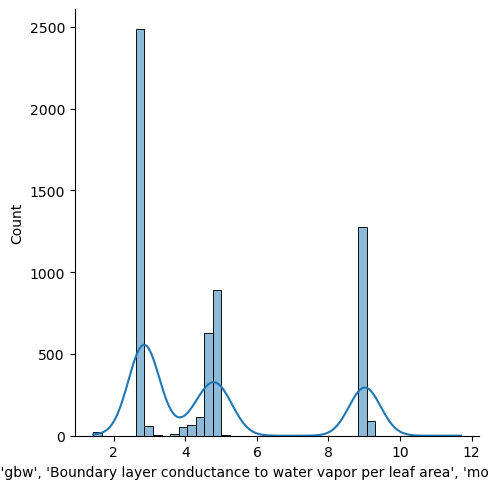

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'ppm')


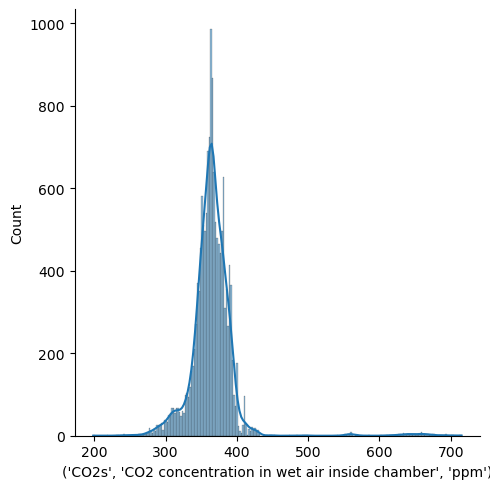

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'ppm')


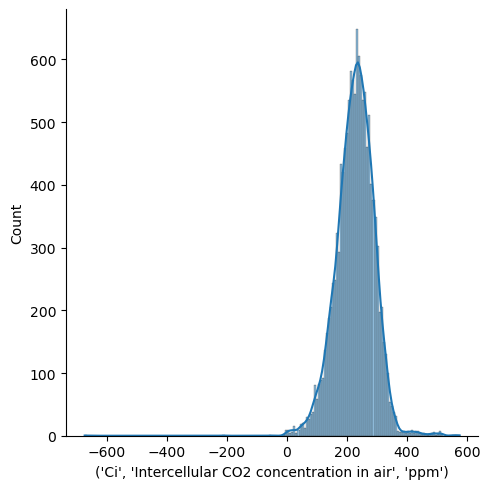

Visualizing ('comments', 'Describe any custom modifications and any other relevant information', 1)


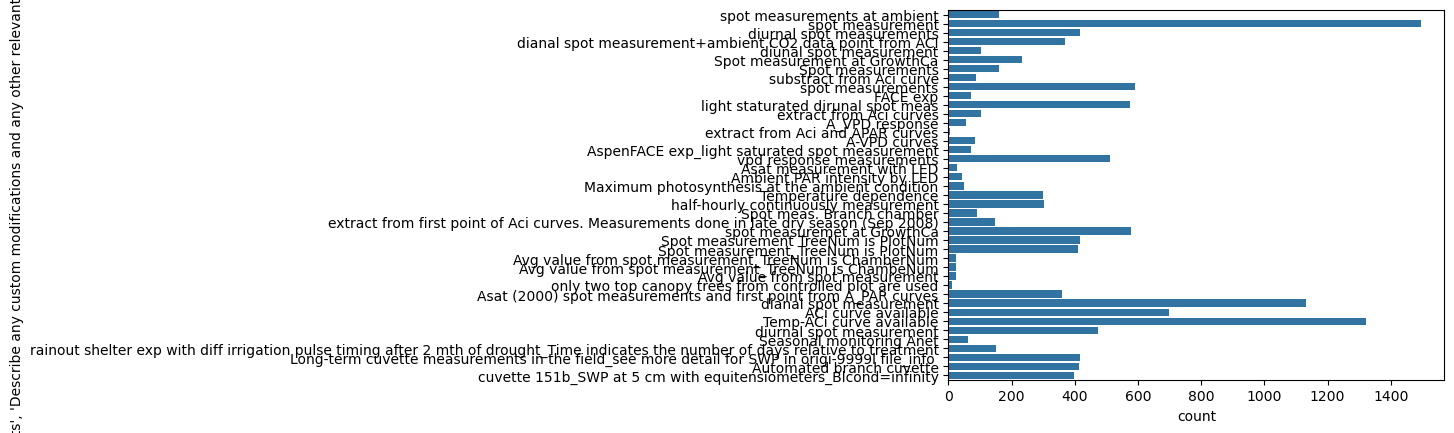

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1')


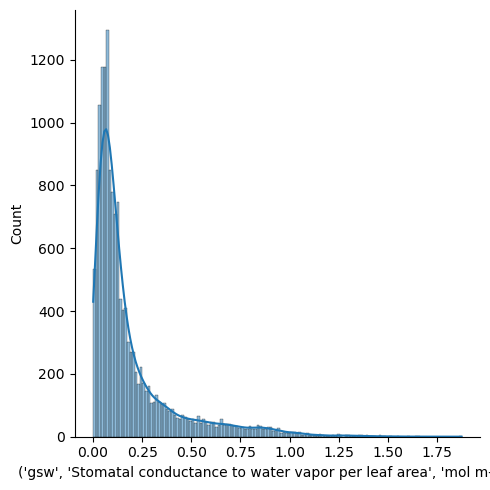

Visualizing ('dataContributor', 'Name of the individual or organization that contributed to the data', 1)


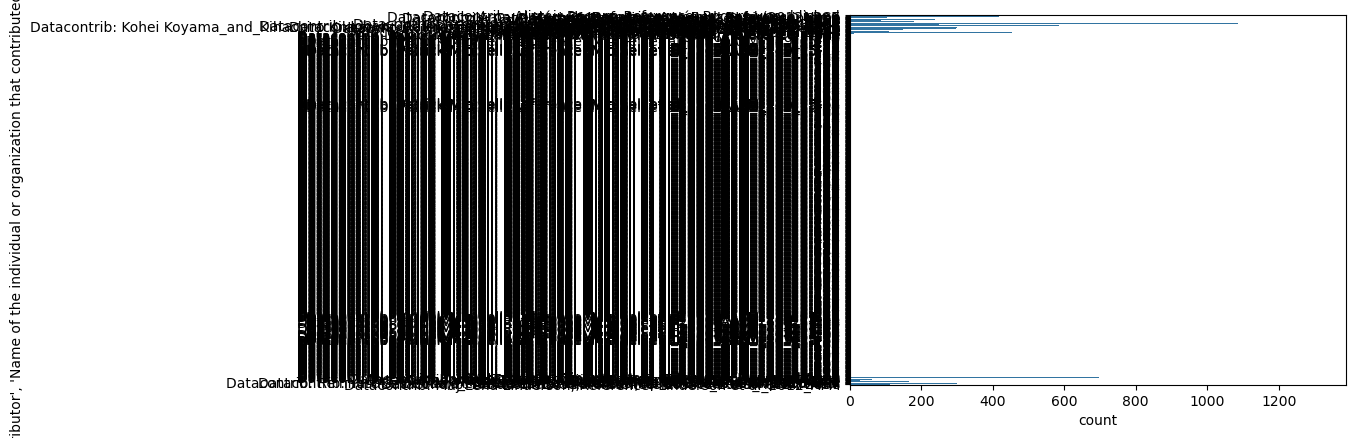

Visualizing ('date', 'Date of observation', 1)


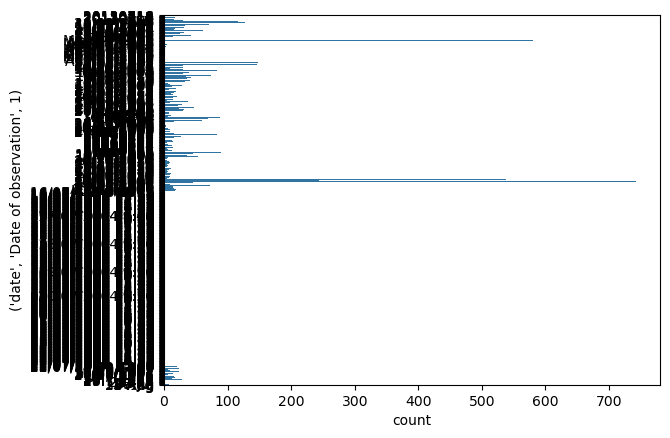

Visualizing ('experimentalTreatment', 'Description of any applied sample manipulations', 1)


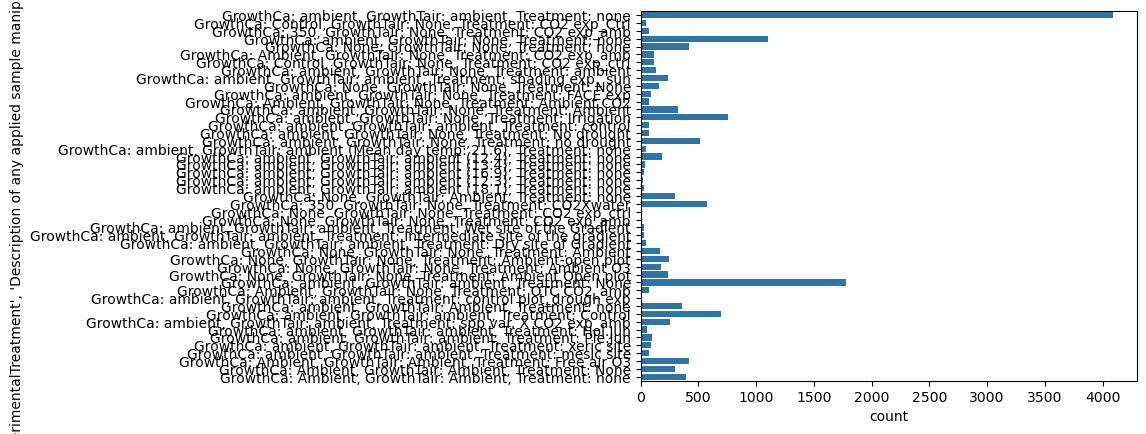

Visualizing ('growthEnvironment', 'Description of the plant growth environment', 1)


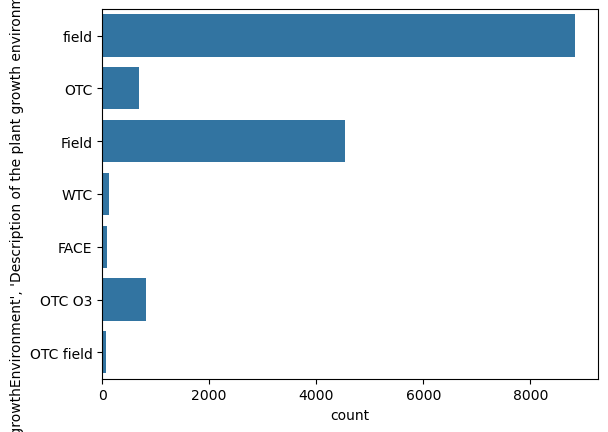

Visualizing ('instrumentType', 'Instrument make & model. Describe any custom modifications in comments', 1)


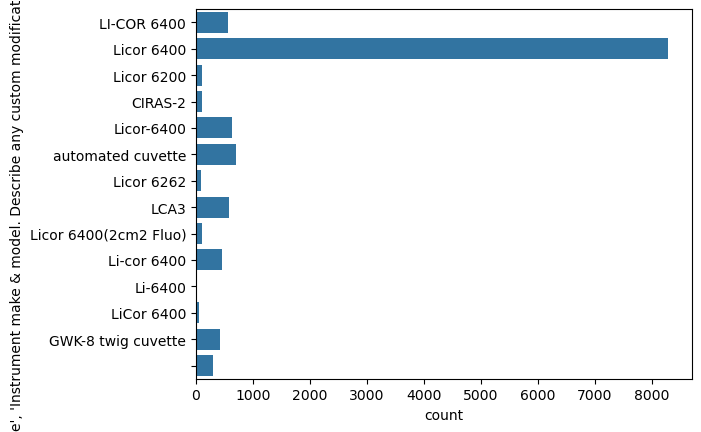

Visualizing ('LAI', 'The ratio of the leaf area to the ground area, which determines plant growth and development patterns', 'm-2 m-2')


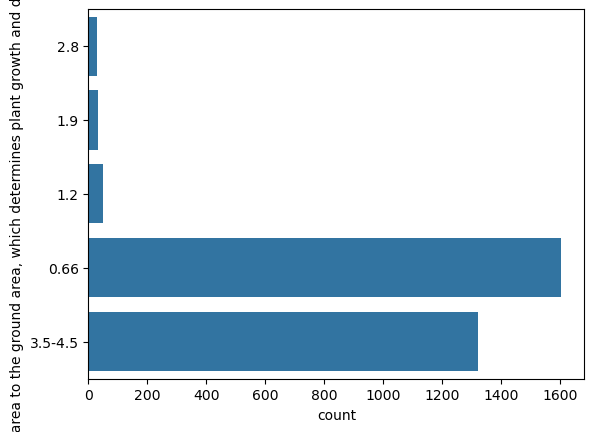

Visualizing ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1)


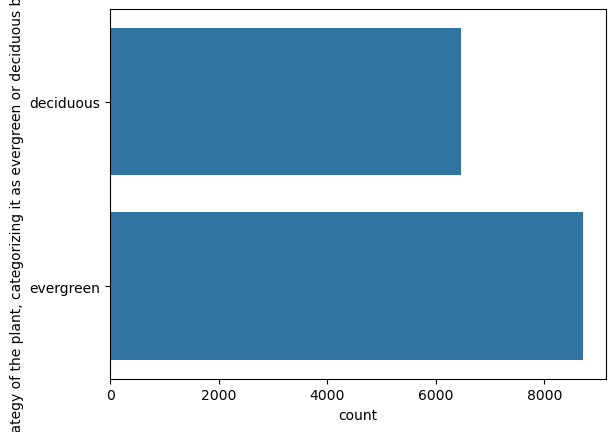

Visualizing ('siteIdentifier', 'Location descriptor of where data was collected', 1)


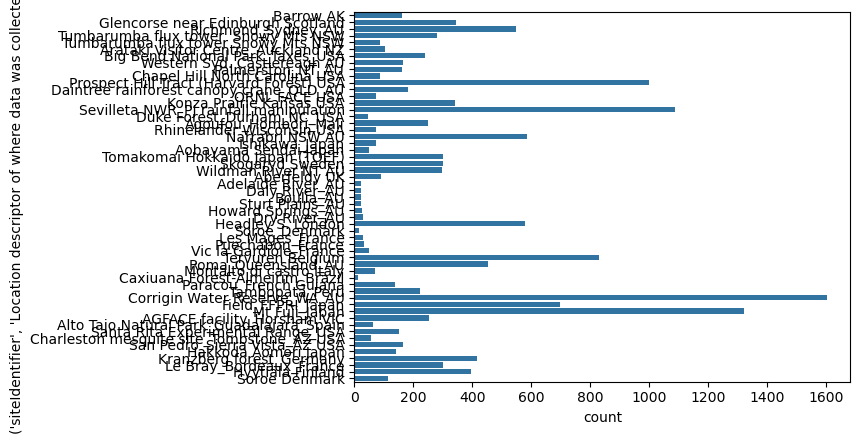

Visualizing ('dataFile', 'File that the data was sourced from', 1)


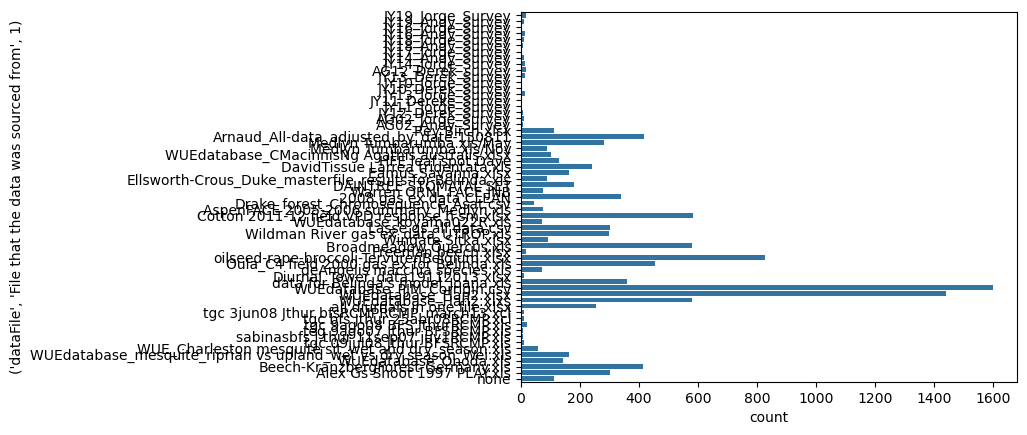

Visualizing ('Qin', 'In-chamber photosynthetic flux density (PPFD) incident on the leaf, quanta per area', 'μmol m-2 s-1')


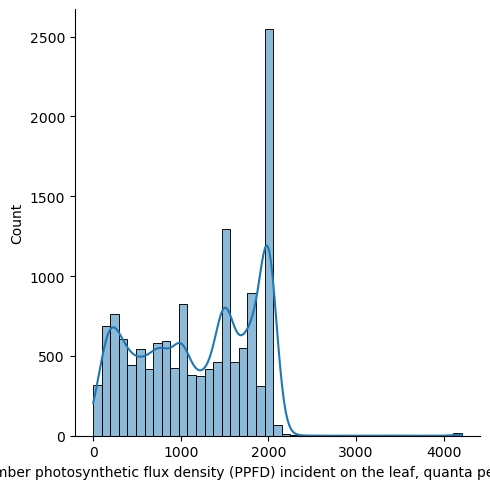

Visualizing ('Patm', 'Atmospheric pressure of the air', 'kPa')


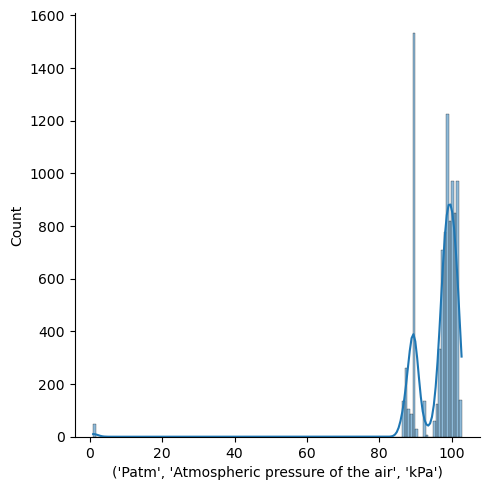

Visualizing ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')


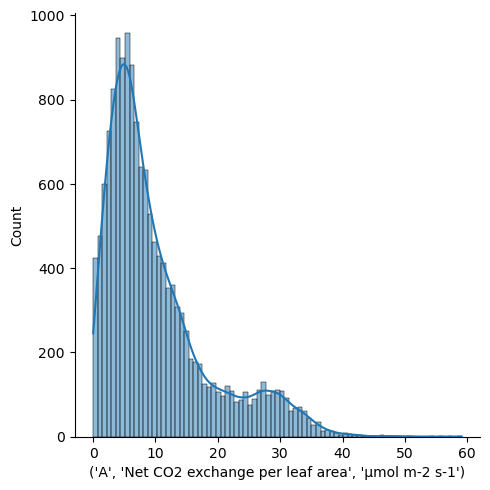

Visualizing ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)


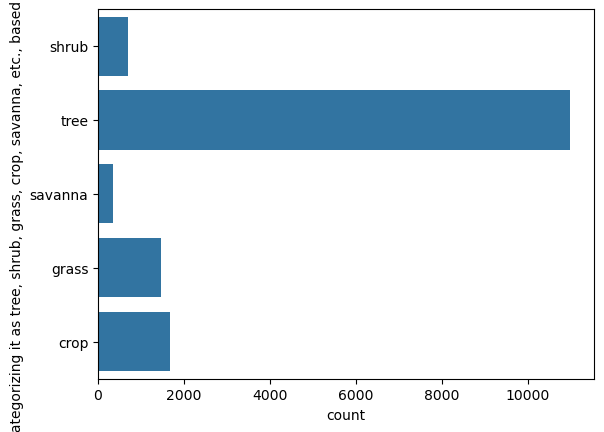

Visualizing ('RHs', 'Relative humidity of air inside the chamber', '%')


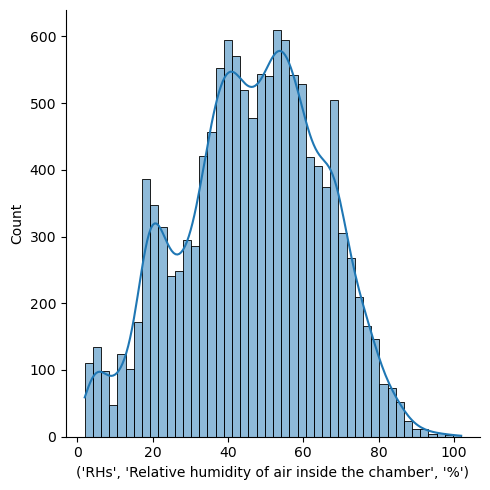

Visualizing ('season', 'Season when the measurement was collected', 1)


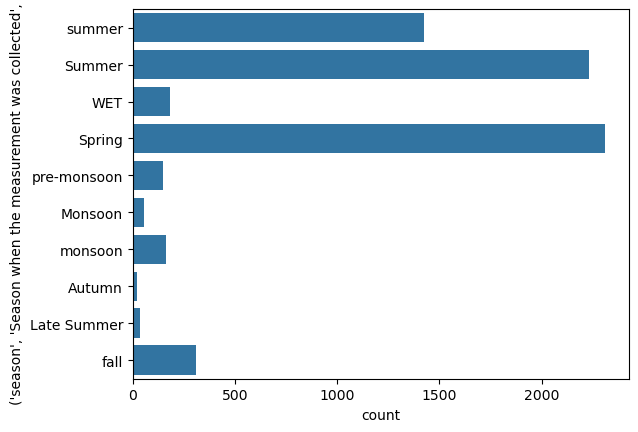

Visualizing ('species', 'Full species name and subspecies if applicable', 1)


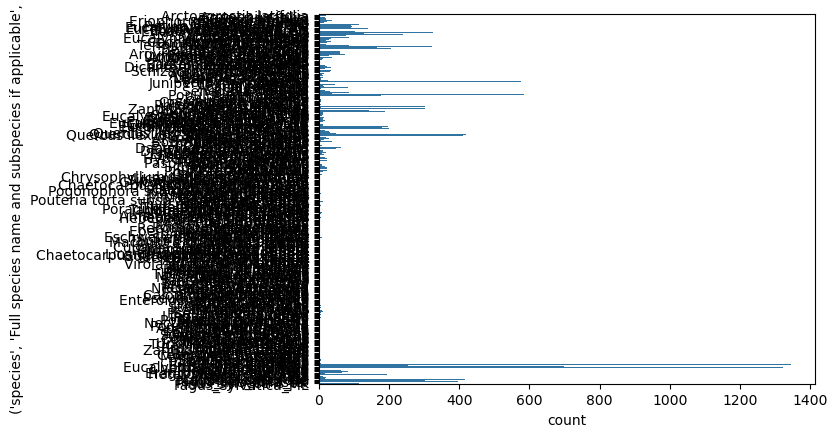

Visualizing ('Tair', 'Air temperature inside the chamber', 'degree_C')


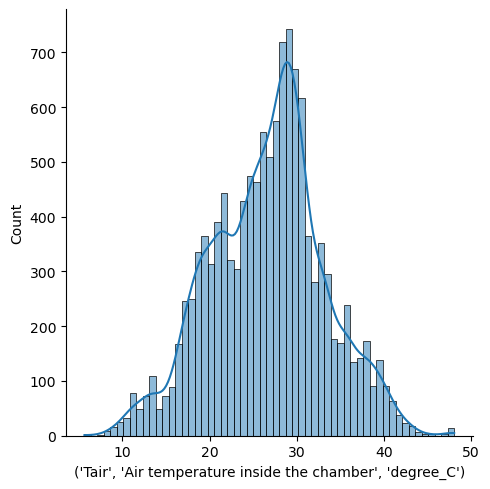

Visualizing ('time', 'Time of observation', 1)


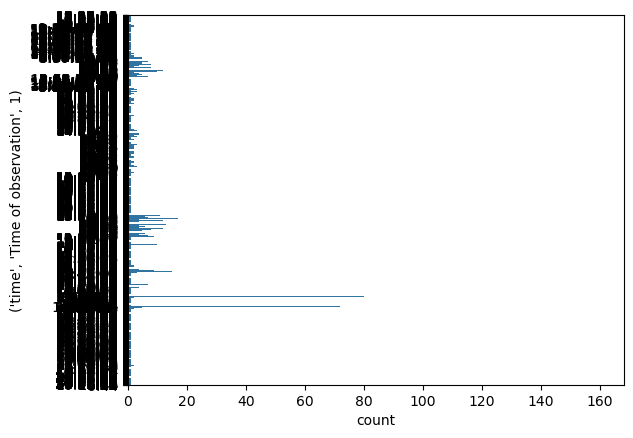

Visualizing ('Tleaf', 'Leaf surface temperature', 'degree_C')


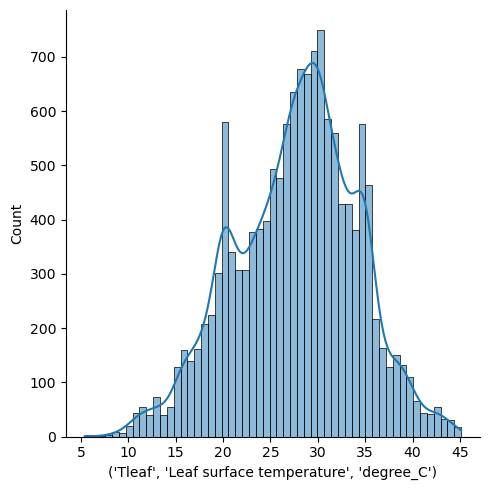

Visualizing ('plantHeight', 'The height of the plant measured', 'm')


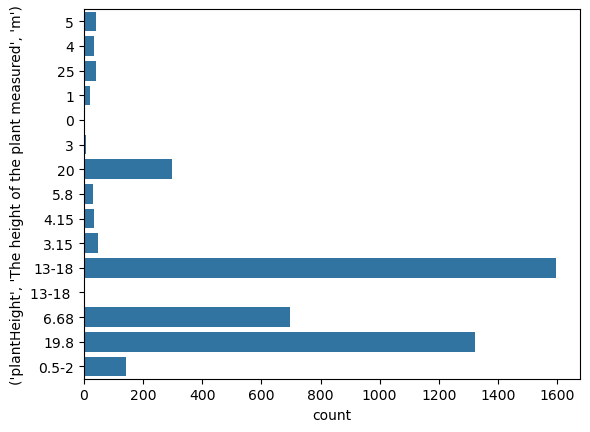

Visualizing ('plantBiome', 'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 1)


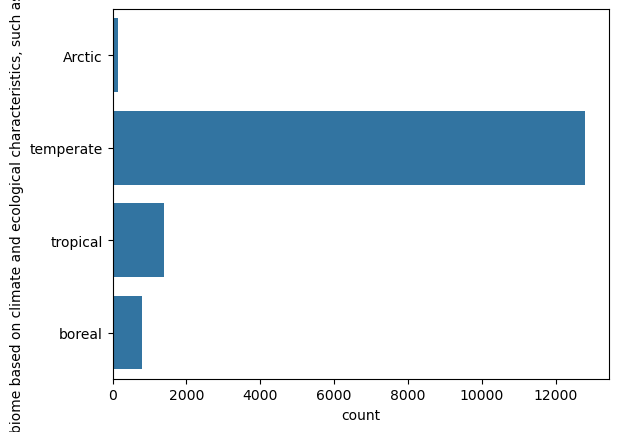

Visualizing ('E', 'Transpiration rate of H2O per leaf area', 'mmol m-2 s-1')


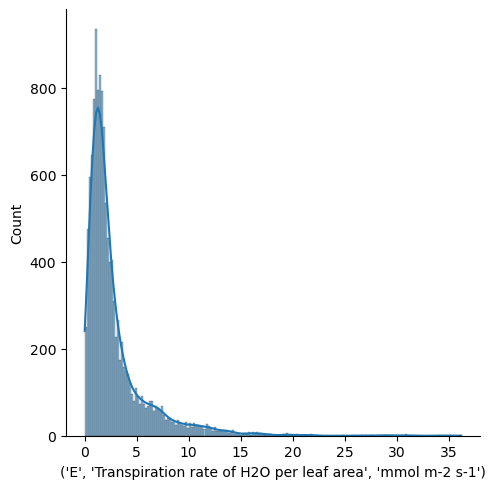

Visualizing ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1)


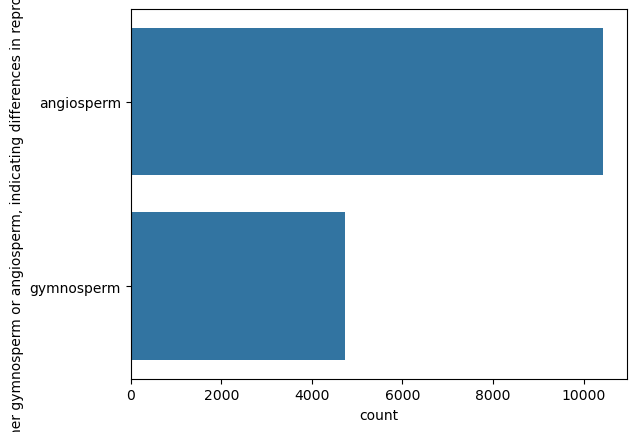

Visualizing ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa')


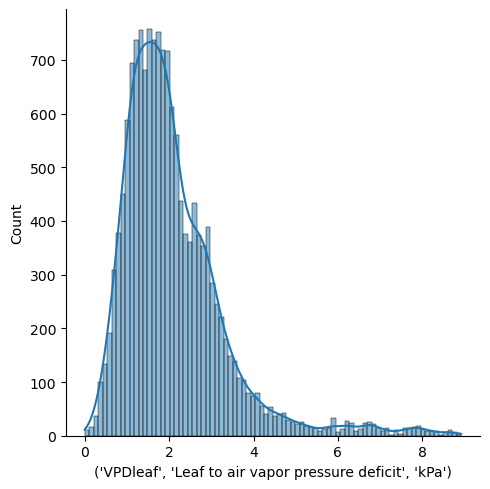

Visualizing ('latitude', 'Latitude coordinate of the site', 'degree')


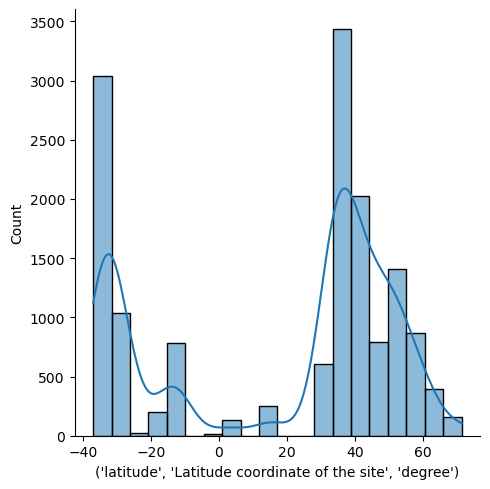

Visualizing ('longitude', 'Longitude coordinate of the site', 'degree')


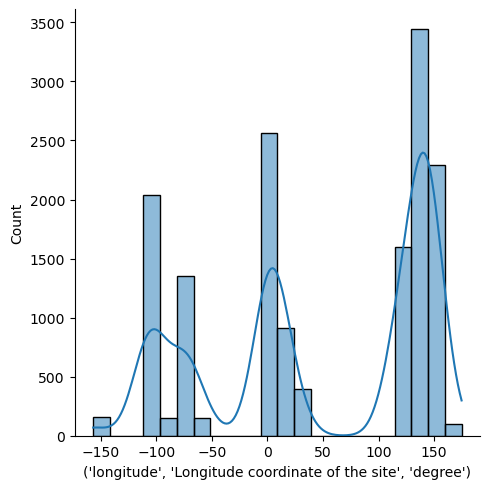

Visualizing ('canopyHeight', 'Sample canopy position and canopy height or LAI recorded', 'm')


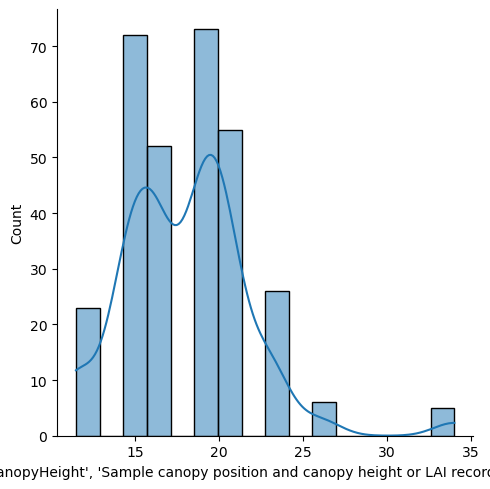

In [30]:
# Iterate over filtered_standard_data columns and visualize
for col in filtered_standard_data.columns:
    print(f"Visualizing {col}")
    funcs.visualize_all_columns(filtered_standard_data[col])

---
---
## 4. Quality Control

---
### 4.1. Strings

In [31]:
# general string cleaning
def clean_string_columns(df):
    # Select only object (string) dtype columns
    string_columns = df.select_dtypes(include=['object']).columns
    df.loc[:, string_columns] = df.loc[:, string_columns].apply(lambda col: col.str.strip().str.lower().str.replace('_', ' '))
    return df

# Apply the function to your DataFrame
filtered_standard_data = clean_string_columns(filtered_standard_data)

In [32]:
# Replace specific values with None
values_to_replace = [-999, -9999, 'none', 'None', np.nan]
filtered_standard_data = filtered_standard_data.replace(values_to_replace, None)

---
### 4.2. Instrument type

In [33]:
# instrument type column
filtered_standard_data[('instrumentType', 'Instrument make & model. Describe any custom modifications in comments', 1)].unique()

array(['li-cor 6400', 'licor 6400', 'licor 6200', 'ciras-2', None,
       'licor-6400', 'automated cuvette', 'licor 6262', 'lca3',
       'licor 6400(2cm2 fluo)', 'li-6400', 'gwk-8 twig cuvette', ''],
      dtype=object)

In [34]:
# measurement device column contd
md_replacement = {'li-cor 6400':'licor 6400', 
                  'ciras-2':'ciras 2', 
                  'licor-6400':'licor 6400', 
                  'lca3':'lca 3',
                  'licor 6400(2cm2 fluo)':'licor 6400', 
                  'li-6400':'licor 6400', 
                  ' ':None,
                  '':None}
filtered_standard_data[('instrumentType', 
                        'Instrument make & model. Describe any custom modifications in comments', 
                        1)] = filtered_standard_data[('instrumentType', 
                                                      'Instrument make & model. Describe any custom modifications in comments', 
                                                      1)].replace(md_replacement)

In [35]:
# post-cleaning
filtered_standard_data[('instrumentType', 'Instrument make & model. Describe any custom modifications in comments', 1)].unique()

array(['licor 6400', 'licor 6200', 'ciras 2', None, 'automated cuvette',
       'licor 6262', 'lca 3', 'gwk-8 twig cuvette'], dtype=object)

In [36]:
# Some of the above are the cuvette configurations, not the instrument type
# These should be separated into a different column
instrument_type_col = ('instrumentType', 'Instrument make & model. Describe any custom modifications in comments', 1)
instrument_chamber_col = ('instrumentChamber', 'Sample chamber or cuvette model. Describe any custom modifications in comments', 1)

# Create the new column if it doesn't already exist
if instrument_chamber_col not in filtered_standard_data.columns:
    filtered_standard_data[instrument_chamber_col] = None

# Define the list of values that actually refer to a cuvette rather than the instrument
cuvette_values = ['automated cuvette', 'gwk-8 twig cuvette']

# Create a boolean mask for rows that have these cuvette values in the instrumentType column
mask = filtered_standard_data[instrument_type_col].isin(cuvette_values)

# Migrate the values from instrumentType to instrumentChamber for these rows
filtered_standard_data.loc[mask, instrument_chamber_col] = filtered_standard_data.loc[mask, instrument_type_col]

# Replace the cuvette values in the instrumentType column with None
filtered_standard_data.loc[mask, instrument_type_col] = None

In [37]:
# Identify rows where instrumentType is 'licor 6400-40'
mask = filtered_standard_data[instrument_type_col] == 'licor 6400-40'

# Update the instrumentType to 'licor 6400'
filtered_standard_data.loc[mask, instrument_type_col] = 'licor 6400'

# Set the instrumentChamber column to the formal name of the -40 cuvette, for example:
filtered_standard_data.loc[mask, instrument_chamber_col] = '6400-40 leaf chamber fluorometer'

In [38]:
filtered_standard_data[('instrumentType', 'Instrument make & model. Describe any custom modifications in comments', 1)].unique()

array(['licor 6400', 'licor 6200', 'ciras 2', None, 'licor 6262', 'lca 3'],
      dtype=object)

In [39]:
filtered_standard_data[('instrumentChamber', 'Sample chamber or cuvette model. Describe any custom modifications in comments', 1)].unique()

array([None, 'automated cuvette', 'gwk-8 twig cuvette'], dtype=object)

---
### 4.3. Season

In [40]:
# season column
filtered_standard_data[('season', 'Season when the measurement was collected', 1)].unique()

array(['summer', None, 'wet', 'spring', 'pre-monsoon', 'monsoon',
       'autumn', 'late summer', 'fall'], dtype=object)

In [41]:
# season contd
s_replacement = {'pre-monsoon':'dry', 
                 'monsoon':'wet', 
                 'autumn':'fall',
                 'late summer':'summer'}
filtered_standard_data.loc[:, ('season', 'Season when the measurement was collected', 1)] = filtered_standard_data[('season', 'Season when the measurement was collected', 1)].replace(s_replacement)

---
### 4.4 Plant height

In [42]:
# plant height
filtered_standard_data[('plantHeight', 'The height of the plant measured', 'm')].unique()

array([None, '5', '4', '25', '0', '3', '20', '5.8', '4.15', '3.15',
       '13-18', '6.68', '19.8', '0.5-2'], dtype=object)

In [43]:
# plant height contd
def convert_to_numeric(value):
    if isinstance(value, float) and pd.isna(value):  # Check if the value is NaN
        return None
    value = str(value)
    if '-' in value:  # Check for ranges
        try:
            parts = list(map(float, value.split('-')))
            return sum(parts) / 2  # Calculate midpoint
        except ValueError:
            return None
    try:
        return float(value)  # Convert to float
    except ValueError:
        return None

# Apply the conversion function
filtered_standard_data.loc[:, ('plantHeight', 'The height of the plant measured', 'm')] = (
    filtered_standard_data[('plantHeight', 'The height of the plant measured', 'm')]
    .apply(convert_to_numeric))

filtered_standard_data.loc[:, ('LAI', 'The ratio of the leaf area to the ground area, which determines plant growth and development patterns', 'm-2 m-2')] = (
    filtered_standard_data[('LAI', 'The ratio of the leaf area to the ground area, which determines plant growth and development patterns', 'm-2 m-2')]
    .apply(convert_to_numeric))

---
### 4.x. Experimental Treatment

In [44]:
conversions = {'growthca: ambient, growthtair: ambient, treatment: none':'ambient',
               'growthca: control, growthtair: none, treatment: co2 exp ctrl':'co2',
               'growthca: 350, growthtair: none, treatment: co2 exp amb':'co2',
               'growthca: ambient, growthtair: none, treatment: none':'ambient',
               'growthca: none, growthtair: none, treatment: none':'ambient',
               'growthca: ambient, growthtair: none, treatment: co2 exp amb':'co2',
               'growthca: ambient, growthtair: none, treatment: ambient':'ambient',
               'growthca: ambient, growthtair: ambient, treatment: shading exp  sun':'shading',
               'growthca: ambient, growthtair: none, treatment: face exp':'ambient',
               'growthca: ambient, growthtair: none, treatment: ambient co2':'ambient',
               'growthca: ambient, growthtair: none, treatment: irrigation':'water',
               'growthca: ambient, growthtair: ambient, treatment: control':'ambient',
               'growthca: ambient, growthtair: none, treatment: no drought':'water',
               'growthca: ambient, growthtair: ambient (mean day temp: 21.6), treatment: none':'ambient',
               'growthca: ambient, growthtair: ambient (12.4), treatment: none':'ambient',
               'growthca: ambient, growthtair: ambient (13.4), treatment: none':'ambient',
               'growthca: ambient, growthtair: ambient (16.9), treatment: none':'ambient',
               'growthca: ambient, growthtair: ambient (12.3), treatment: none':'ambient',
               'growthca: ambient, growthtair: ambient (18.1), treatment: none':'ambient',
               'growthca: none, growthtair: ambient, treatment: none':'ambient',
               'growthca: 350, growthtair: none, treatment: co2xwater':'co2 and water',
               'growthca: none, growthtair: none, treatment: co2 exp ctrl':'co2',
               'growthca: none, growthtair: none, treatment: co2 exp amb':'co2',
               'growthca: ambient, growthtair: ambient, treatment: wet site of the gradient':'water',
               'growthca: ambient, growthtair: ambient, treatment: intermediate site of the gradient':'water',
               'growthca: ambient, growthtair: ambient, treatment: dry site of gradient':'water',
               'growthca: none, growthtair: none, treatment: ambient':'ambient',
               'growthca: none, growthtair: none, treatment: ambient-open plot':'ambient',
               'growthca: none, growthtair: none, treatment: ambient o3':'ozone',
               'growthca: none, growthtair: none, treatment: ambient open plot':'ambient',
               'growthca: ambient, growthtair: none, treatment: otc co2 amb':'co2',
               'growthca: ambient, growthtair: ambient, treatment: control plot drough exp':'water',
               'growthca: ambient, growthtair: ambient, treatment: spp var. x co2 exp amb':'co2',
               'growthca: ambient, growthtair: ambient, treatment: hol.jun':'ambient',
               'growthca: ambient, growthtair: ambient, treatment: ple.jun':'ambient',
               'growthca: ambient, growthtair: ambient, treatment: xeric site':'ambient',
               'growthca: ambient, growthtair: ambient, treatment: mesic site':'ambient',
               'growthca: ambient, growthtair: ambient, treatment: free air o3':'ozone'}

In [45]:
# apply conversions
filtered_standard_data[('experimentalTreatment', 
                        'Description of any applied sample manipulations', 
                        1)] = filtered_standard_data[('experimentalTreatment', 
                                                      'Description of any applied sample manipulations', 
                                                      1)].replace(conversions)

---
### 4.x. Growth environment

In [46]:
filtered_standard_data[('growthEnvironment', 'Description of the plant growth environment', 1)].unique()

array(['field', 'otc', 'wtc', 'face', 'otc o3', 'otc field'], dtype=object)

In [47]:
# convert growthEnvironment strings to a standard
# options so far: open, open top chamber, free-air co2 enrichment system, whole-tree chamber
conversions = {'field':'open', 
               'otc':'open top chamber', 
               'wtc':'whole-tree chamber', 
               'face':'free-air co2 enrichment system', 
               'otc o3':'open top chamber', 
               'otc field':'open top chamber'}
filtered_standard_data[('growthEnvironment', 
                        'Description of the plant growth environment', 
                        1)] = filtered_standard_data[('growthEnvironment', 
                                                      'Description of the plant growth environment', 
                                                      1)].replace(conversions)

---
### 4.5. Dates/Times
* Create a .csv `../data/temp/datetmes/{filename}_datetime_formatting.csv` with headers `source`, `datetime_formats`, `time_formats`, and `dayfirst`
* Assign a list of datetime formats, time formats, and dayfirst info (whether or not the date starts with a day) in `{filename}_datetime_formatting.csv`
    * Assign these special cases where necessary:
        * decimal_hours (time is in decimal hours), total_minutes (time is in total minutes), date_with_time (date contains time information), range_of_days (date is a range of days, e.g., 1-2 September 2024)
        * add more special case handling in the `funcs.process_datetime()` as needed
* Export filled in `../data/temp/datetmes/{filename}_datetime_formatting.csv` as `../data/temp/datetmes/{filename}_datetime_formatting_01.csv`

In [48]:
# As you can see below, there is a mix of date formats. Annoying.
filtered_standard_data[('date', 'Date of observation', 1)].unique()

array(['20130719', '20130716', '20130718', '20130717', '20130714',
       '20120812', '20130713', '20130710', '20130711', '20130712',
       '20130802', 'jun', 'sep', 'july', 'aug', '26/02/2010',
       '18/03/2010', '10/02/2010', '14/02/2002', '12/02/2002',
       '13/02/2002', '11/02/2002', '15/02/2002', '14/11/2001',
       '15/11/2001', '16/11/2001', '24/01/2013', '24/08/1993',
       '10/08/1993', '22/07/1993', '13/07/1993', '29/09/1993',
       '28/09/1993', '12/07/1993', '6/08/1993', None, '4/10/2005',
       '3/10/2005', '2/10/2005', '5/10/2005', '13/12/2006', '14/12/2006',
       '7/05/2007', '31/07/2007', '8/05/2007', '5/06/2007', '6/06/2007',
       '1-mar-97', '1-apr-97', '1-jul-97', '1-aug-97', '1-dec-97',
       '16/12/2000', 'aug 7 2006', 'aug 9 2006', '24/05/2003',
       'may 22 1998', '26/05/2003', '27/05/2003', 'may  9 1998',
       '20/07/2001', '17/08/2003', '31/05/2001', '18/08/2003',
       'may 21 2005', 'may  5 1998', '5/10/2004', '30/05/2001',
       '22/04/19

In [49]:
# export temp datetime file assuming there are dataContributor and siteIdentifier columns
funcs.create_datetime_temp(filtered_standard_data, filename)

Exported datetime template to ../data/temp/datetimes/lin_2015_datetime_formatting_temp.csv


### --> Fill out datetime_temp file manually <--

In [50]:
# create and read csv where I've manually assigned each source the datetime, time, and day-first by looking at the original data
df = pd.read_csv(f'../data/temp/datetimes/{filename}_datetime_formatting.csv')
df.head(3)

,source,datetime_formats,time_formats,dayfirst
0,alexandrebosc,['%d/%m/%Y'],['%H:%M'],[True]
1,alistair rogers,['%Y%m%d'],['%H:%M:%S'],[False]
2,ana rey,"['%b', '%B']",[],[False]


In [51]:
# convert the df into a dictionary format
source_formats = {
    row["source"]: {
        "datetime_formats": eval(row["datetime_formats"].replace("‘", "'").replace("’", "'")),
        "time_formats": eval(row["time_formats"].replace("‘", "'").replace("’", "'")),
        "dayfirst": eval(row["dayfirst"].replace("‘", "'").replace("’", "'"))
    }
    for _, row in df.iterrows()
}

In [53]:
# apply processing by group
results = []
for source, group in filtered_standard_data.groupby(("dataContributor", "Name of the individual or organization that contributed to the data", 1)):
    formats = source_formats.get(source, {})
    group[[('original_date', 'Original date', 1), ('original_time', 'Original time', 1), ('year', 'Year of observation', 1), ('month', 'Month of observation', 1), ('day', 'Day of observation', 1),('time', 'Time of observation', 1)]] = group.apply(
        lambda x: pd.Series(funcs.process_datetime(x, formats)), axis=1
    )
    results.append(group)

# Concatenate the processed groups
filtered_standard_data2 = pd.concat(results)
filtered_standard_data2.head(3)

standard_variable,gbw,CO2s,Ci,comments,gsw,dataContributor,date,experimentalTreatment,growthEnvironment,instrumentType,...,VPDleaf,latitude,longitude,canopyHeight,instrumentChamber,original_date,original_time,year,month,day
standard_description,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Describe any custom modifications and any other relevant information,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Date of observation,Description of any applied sample manipulations,Description of the plant growth environment,Instrument make & model. Describe any custom modifications in comments,...,Leaf to air vapor pressure deficit,Latitude coordinate of the site,Longitude coordinate of the site,Sample canopy position and canopy height or LAI recorded,Sample chamber or cuvette model. Describe any custom modifications in comments,Original date,Original time,Year of observation,Month of observation,Day of observation
unit,mol m-2 s-1,ppm,ppm,1,mol m-2 s-1,1,1,1,1,1,...,kPa,degree,degree,m,1,1,1,1,1,1
14354,None,344.69618,None,automated branch cuvette,0.064946,"datacontrib: alexandrebosc, reference: bosc a ...",12/09/1997,ambient,open,None,...,0.297887,44.72,-0.77,None,None,12/09/1997,8:42,None,None,None
14355,None,345.856981,None,automated branch cuvette,0.06968,"datacontrib: alexandrebosc, reference: bosc a ...",12/09/1997,ambient,open,None,...,0.369804,44.72,-0.77,None,None,12/09/1997,9:02,None,None,None
14356,None,343.936307,None,automated branch cuvette,0.079565,"datacontrib: alexandrebosc, reference: bosc a ...",12/09/1997,ambient,open,None,...,0.473783,44.72,-0.77,None,None,12/09/1997,9:22,None,None,None


---
### 4.6. Species names
For this Lin 2015 data, I wanted a visual aid to make sure I was adjusting species names correctly, so I generated a unique ID for each data source and species. That way, I can capture when a data source recorded information for multiple species

In [54]:
def generate_row_id(row, id_fields, prefix_sep='_', hash_exclude_fields=None):
    """
    Generate a unique ID for a row based on specified fields and a hash of the rest of the row.
    
    Parameters:
    - row (dict or pandas.Series): The row of data.
    - id_fields (list): List of fields to include in the prefix.
    - prefix_sep (str): Separator for the prefix fields.
    - hash_exclude_fields (list): Fields to exclude from the hash. If None, use id_fields.
    
    Returns:
    - str: A unique identifier in the format "file_contributor_site_species_<hash>".
    """
    # Ensure hash_exclude_fields defaults to id_fields if not provided
    if hash_exclude_fields is None:
        hash_exclude_fields = id_fields
    
    # Create prefix using specified fields (replace None or missing values with "none")
    prefix = prefix_sep.join(str(row.get(field, 'none') or 'none') for field in id_fields)
    
    # Return the full ID
    return prefix

In [55]:
# Fields for prefix
id_fields = [
    ('dataContributor', 'Name of the individual or organization that contributed to the data', 1),
    ('siteIdentifier', 'Location descriptor of where data was collected', 1),
    ('species', 'Full species name and subspecies if applicable', 1)
]

# Generate unique ID and assign it to the new multi-index column
new_col = ('uid', 'Unique data row identifier', 1)
filtered_standard_data2[new_col] = pd.Series(
    filtered_standard_data2.apply(lambda row: generate_row_id(row, id_fields), axis=1),
    index=filtered_standard_data2.index
)

In [56]:
filtered_standard_data2.head(3)

standard_variable,gbw,CO2s,Ci,comments,gsw,dataContributor,date,experimentalTreatment,growthEnvironment,instrumentType,...,latitude,longitude,canopyHeight,instrumentChamber,original_date,original_time,year,month,day,uid
standard_description,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Describe any custom modifications and any other relevant information,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Date of observation,Description of any applied sample manipulations,Description of the plant growth environment,Instrument make & model. Describe any custom modifications in comments,...,Latitude coordinate of the site,Longitude coordinate of the site,Sample canopy position and canopy height or LAI recorded,Sample chamber or cuvette model. Describe any custom modifications in comments,Original date,Original time,Year of observation,Month of observation,Day of observation,Unique data row identifier
unit,mol m-2 s-1,ppm,ppm,1,mol m-2 s-1,1,1,1,1,1,...,degree,degree,m,1,1,1,1,1,1,1
14354,None,344.69618,None,automated branch cuvette,0.064946,"datacontrib: alexandrebosc, reference: bosc a ...",12/09/1997,ambient,open,None,...,44.72,-0.77,None,None,12/09/1997,8:42,None,None,None,"datacontrib: alexandrebosc, reference: bosc a ..."
14355,None,345.856981,None,automated branch cuvette,0.06968,"datacontrib: alexandrebosc, reference: bosc a ...",12/09/1997,ambient,open,None,...,44.72,-0.77,None,None,12/09/1997,9:02,None,None,None,"datacontrib: alexandrebosc, reference: bosc a ..."
14356,None,343.936307,None,automated branch cuvette,0.079565,"datacontrib: alexandrebosc, reference: bosc a ...",12/09/1997,ambient,open,None,...,44.72,-0.77,None,None,12/09/1997,9:22,None,None,None,"datacontrib: alexandrebosc, reference: bosc a ..."


#### What to look for in Lin 2015 species names:
- Abbreviations: 'euc saligna de' should be 'eucalyptus salinga'
- UIDs: I think to differentiate the data source that added the author initials at the end of the species name
    - E.g. 'fagus sylvatica mf', 'fagus sylvatica ml', 'fagus sylvatica rc'
    - Also 'repeat' added at the end of species names
- There's also common names like 'bindweed'
- Some genus only names ('cenchrus', 'alysicarpus')
- Misspellings probably: ('caraipa myrcioides', 'carapa procera')
- Places: Things like 'stpaul vic la gardiole' after a species name.
    - Should remove these but ensure there is a siteIdentifier associated with the species

In [57]:
# instantiate species checklist
u_species = filtered_standard_data2[[('species', 'Full species name and subspecies if applicable', 1),
                       ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1),
                       ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
                       ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)]].drop_duplicates()
u_species.columns = u_species.columns.get_level_values(0)
u_species = u_species.rename(columns={'species':'unadjudicatedName'})
u_species = u_species.sort_values(by='unadjudicatedName')
u_species

standard_variable,unadjudicatedName,plantType,plantLeaf,plantForm
1931,acacia mimula,angiosperm,evergreen,savanna
4902,acacia raddiana,angiosperm,deciduous,savanna
5881,acer nikoense,angiosperm,deciduous,tree
2179,acer rubrum,angiosperm,deciduous,tree
3177,acmena graveolens,angiosperm,evergreen,tree
...,...,...,...,...
9220,vismia sessilifolia,angiosperm,evergreen,tree
9170,vouacapoua americana,angiosperm,evergreen,tree
9427,zanthoxylum acreanum,angiosperm,evergreen,tree
5925,zanthoxylum ailanthoides,angiosperm,deciduous,tree


---
### 4.7. Instantiate the species lookup table as `filename_species_lookup.csv`

In [58]:
# add missing columns
u_species['acceptedName'] = None
u_species['nameAuthor'] = None
u_species['nameAuthority'] = None
u_species['nameCategory'] = None
u_species['nameAdjudicator'] = None

# export checklist
u_species.to_csv(f'../data/temp/species/{filename}_species_lookup.csv')

---
### 4.8. Fill in the lookup table information save as `filename_species_lookup_01.csv`
We recommend passing this task on to an expert who can parse through synonymous, mispelled, and misapplied names

In [59]:
# load edited species checklist (species_checklist_01)
species_checklist = pd.read_csv(f'../data/temp/species/{filename}_species_lookup_01.csv', index_col=0)
species_checklist = species_checklist.replace({np.nan: None})
species_checklist

,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
1929,acacia mimula,angiosperm,evergreen,savanna,acacia mimula,None,None,species,None
4900,acacia raddiana,angiosperm,deciduous,savanna,acacia raddiana,None,None,species,None
5879,acer nikoense,angiosperm,deciduous,tree,acer nikoense,None,None,species,None
2177,acer rubrum,angiosperm,deciduous,tree,acer rubrum,None,None,species,None
3175,acmena graveolens,angiosperm,evergreen,tree,acmena graveolens,None,None,species,None
...,...,...,...,...,...,...,...,...,...
9218,vismia sessilifolia,angiosperm,evergreen,tree,vismia sessilifolia,None,None,species,None
9168,vouacapoua americana,angiosperm,evergreen,tree,vouacapoua americana,None,None,species,None
9425,zanthoxylum acreanum,angiosperm,evergreen,tree,zanthoxylum acreanum,None,None,species,None
5923,zanthoxylum ailanthoides,angiosperm,deciduous,tree,zanthoxylum ailanthoides,None,None,species,None


#### 4.8.1. Format the lookup table headers for merging new columns to the data

In [60]:
# make single headers into multi-headers
new_columns = pd.MultiIndex.from_tuples([
    ('unadjudicatedName', 'Full species name and subspecies if applicable', 1),  # Matching the multi-header in filtered_standard_data2
    ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1),
    ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
    ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1),
    ('acceptedName', 'The accepted species name assigned by the adjudicator', 1),
    ('nameAuthor', 'The author of the accepted species name', 1),
    ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1),
    ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1),
    ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1)
])
species_checklist.columns = new_columns

#### 4.8.2. Merge the species data to filtered_standard_data

In [61]:
# merge checklist to filtered_standard_data
merged_df = pd.merge(
    filtered_standard_data2,
    species_checklist,
    left_on=[('species', 'Full species name and subspecies if applicable', 1)],
    right_on=[('unadjudicatedName', 'Full species name and subspecies if applicable', 1)],
    how='left'
)

#### 4.8.3. Drop some overlapped columns from the merged dataframe

In [62]:
# rename columns
columns_to_drop = [('plantType_y',
                    'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage',
                    1),
                   ('plantLeaf_y',
                    'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns',
                    1),
                   ('plantForm_y',
                    'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function',
                    1),
                   ('date', 'Date of observation', 1),
                   ('original_date', 'Original date', 1),
                   ('original_time', 'Original time', 1),
                   ('species', 'Full species name and subspecies if applicable', 1)]

# Drop the specified columns
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)
merged_df.columns = pd.MultiIndex.from_tuples([
    (col[0].replace('_x', ''), *col[1:]) for col in merged_df.columns
])
merged_df.head(3)

,gbw,CO2s,Ci,comments,gsw,dataContributor,experimentalTreatment,growthEnvironment,instrumentType,LAI,...,year,month,day,uid,unadjudicatedName,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Describe any custom modifications and any other relevant information,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Description of any applied sample manipulations,Description of the plant growth environment,Instrument make & model. Describe any custom modifications in comments,"The ratio of the leaf area to the ground area, which determines plant growth and development patterns",...,Year of observation,Month of observation,Day of observation,Unique data row identifier,Full species name and subspecies if applicable,The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,mol m-2 s-1,ppm,ppm,1,mol m-2 s-1,1,1,1,1,m-2 m-2,...,1,1,1,1,1,1,1,1,1,1
0,None,344.69618,None,automated branch cuvette,0.064946,"datacontrib: alexandrebosc, reference: bosc a ...",ambient,open,None,NaN,...,None,None,None,"datacontrib: alexandrebosc, reference: bosc a ...",pinus pinaster,pinus pinaster,None,None,species,None
1,None,345.856981,None,automated branch cuvette,0.06968,"datacontrib: alexandrebosc, reference: bosc a ...",ambient,open,None,NaN,...,None,None,None,"datacontrib: alexandrebosc, reference: bosc a ...",pinus pinaster,pinus pinaster,None,None,species,None
2,None,343.936307,None,automated branch cuvette,0.079565,"datacontrib: alexandrebosc, reference: bosc a ...",ambient,open,None,NaN,...,None,None,None,"datacontrib: alexandrebosc, reference: bosc a ...",pinus pinaster,pinus pinaster,None,None,species,None


In [63]:
# set dtypes
column_data_types = {
    ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1'): 'Float64',
    ('CO2s', 'CO2 concentration in wet air inside chamber', 'ppm'): 'Float64',
    ('Ci', 'Intercellular CO2 concentration in air', 'ppm'): 'Float64',
    ('E', 'Transpiration rate of H2O per leaf area', 'mmol m-2 s-1'): 'Float64',
    ('LAI', 'The ratio of the leaf area to the ground area, which determines plant growth and development patterns', 'm-2 m-2'): 'Float64',
    ('Patm', 'Atmospheric pressure of the air', 'kPa'): 'Float64',
    ('Qin', 'In-chamber photosynthetic flux density (PPFD) incident on the leaf, quanta per area', 'μmol m-2 s-1'): 'Float64',
    ('RHs', 'Relative humidity of air inside the chamber', '%'): 'Float64',
    ('Tair', 'Air temperature inside the chamber', 'degree_C'): 'Float64',
    ('Tleaf', 'Leaf surface temperature', 'degree_C'): 'Float64',
    ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa'): 'Float64',
    ('acceptedName', 'The accepted species name assigned by the adjudicator', 1): 'str',
    ('dataContributor', 'Name of the individual or organization that contributed to the data', 1): 'str',
    ('day', 'Day of observation', 1): 'Int64',
    ('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1): 'str',
    ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1'): 'Float64',
    ('growthEnvironment', 'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 1): 'str',
    ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1'): 'Float64',
    ('latitudeY', 'Latitude coordinate of the site', 'degree'): 'Float64',
    ('longitudeX', 'Longitude coordinate of the site', 'degree'): 'Float64',
    ('measurementDevice', 'Name of the instrument that collected data', 1): 'str',
    ('month', 'Month of observation', 1): 'Int64',
    ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1): 'str',
    ('nameAuthor', 'The author of the accepted species name', 1): 'str',
    ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1): 'str',
    ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1): 'str',
    ('plantBiome', 'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 1): 'str',
    ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1): 'str',
    ('plantHeight', 'The height of the plant measured', 'm'): 'Float64',
    ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1): 'str',
    ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1): 'str',
    ('season', 'Season when the measurement was collected', 1): 'str',
    ('siteIdentifier', 'Location descriptor of where data was collected', 1): 'str',
    ('time', 'Time of observation', 1): 'str',
    ('uid', 'Unique data row identifier', 1): 'str',
    ('unadjudicatedName', 'Full species name and subspecies if applicable', 1): 'str',
    ('year', 'Year of observation', 1): 'Int64'
}

In [64]:
# assign data types
merged_df = merged_df.astype(column_data_types)
merged_df.head(3)

KeyError: "Only a column name can be used for the key in a dtype mappings argument. '('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1)' not found in columns."

---
---
## 5. Unit conversion

In [51]:
# Create a deep copy of merged_df
merged_df_2 = merged_df.copy(deep=True)
merged_df_2, preconverted_cols, converted_cols = funcs.check_and_convert_units(column_standards, merged_df_2)

Mismatch found: gbw (Boundary layer conductance to water vapor per leaf area) - mol m-2 s-1 to mmol m-2 s-1
Converted data from mol m-2 s-1 to mmol m-2 s-1: min=1420.0, max=11701.86915
Converted units and updated header.
Mismatch found: CO2s (CO2 concentration in wet air inside chamber) - ppm to μmol mol-1
Converted data from ppm to μmol mol-1: min=198.2716667, max=715.2340516
Converted units and updated header.
Mismatch found: Ci (Intercellular CO2 concentration in air) - ppm to μmol mol-1
Converted data from ppm to μmol mol-1: min=-674.0, max=575.2356404
Converted units and updated header.
Mismatch found: gsw (Stomatal conductance to water vapor per leaf area) - mol m-2 s-1 to mmol m-2 s-1
Converted data from mol m-2 s-1 to mmol m-2 s-1: min=1.1800000000000002, max=1873.910214
Converted units and updated header.


In [52]:
preconverted_cols

[('gbw',
  'Boundary layer conductance to water vapor per leaf area',
  'mol m-2 s-1'),
 ('CO2s', 'CO2 concentration in wet air inside chamber', 'ppm'),
 ('Ci', 'Intercellular CO2 concentration in air', 'ppm'),
 ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1')]

---
### 5.1. Visualize and confirm unit conversions

Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mmol m-2 s-1')


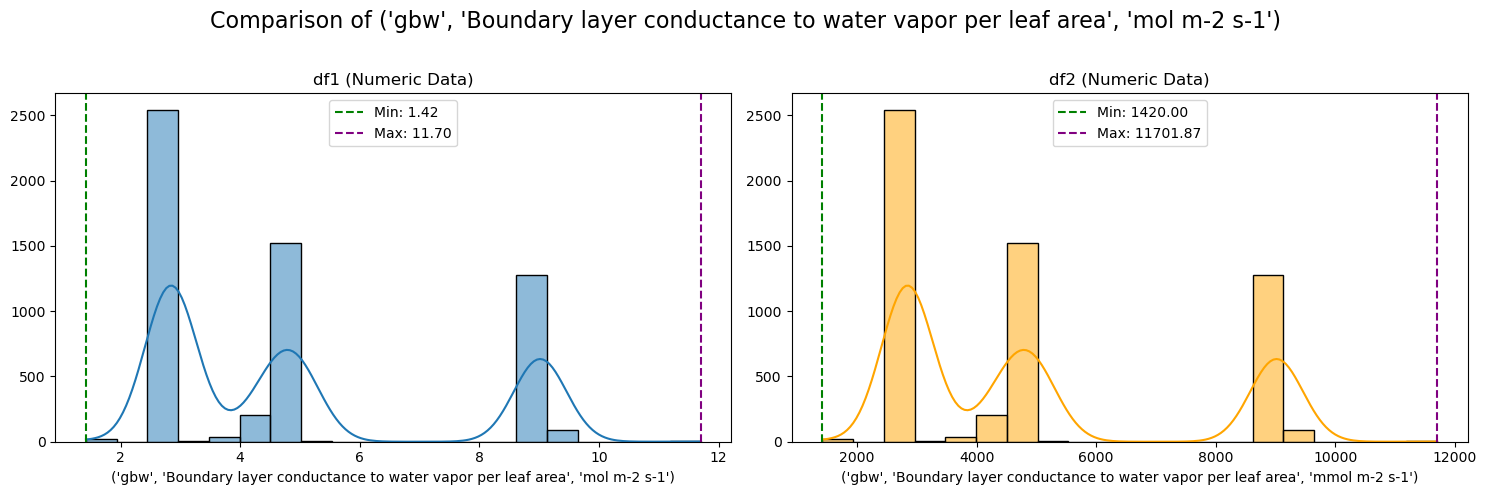

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'ppm') and ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


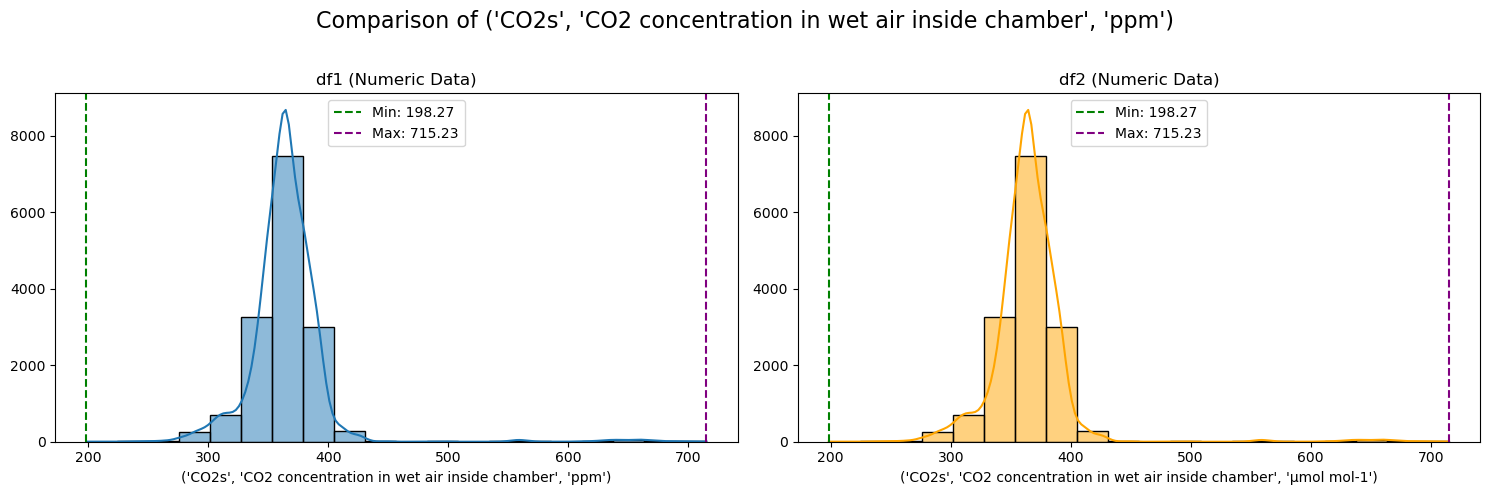

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'ppm') and ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


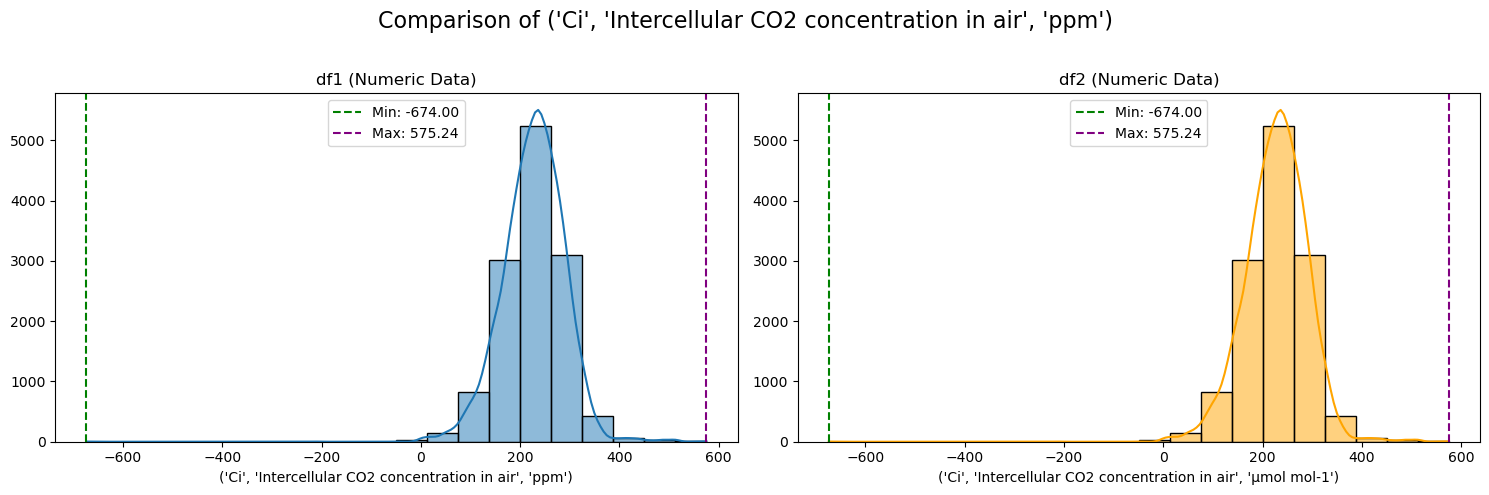

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


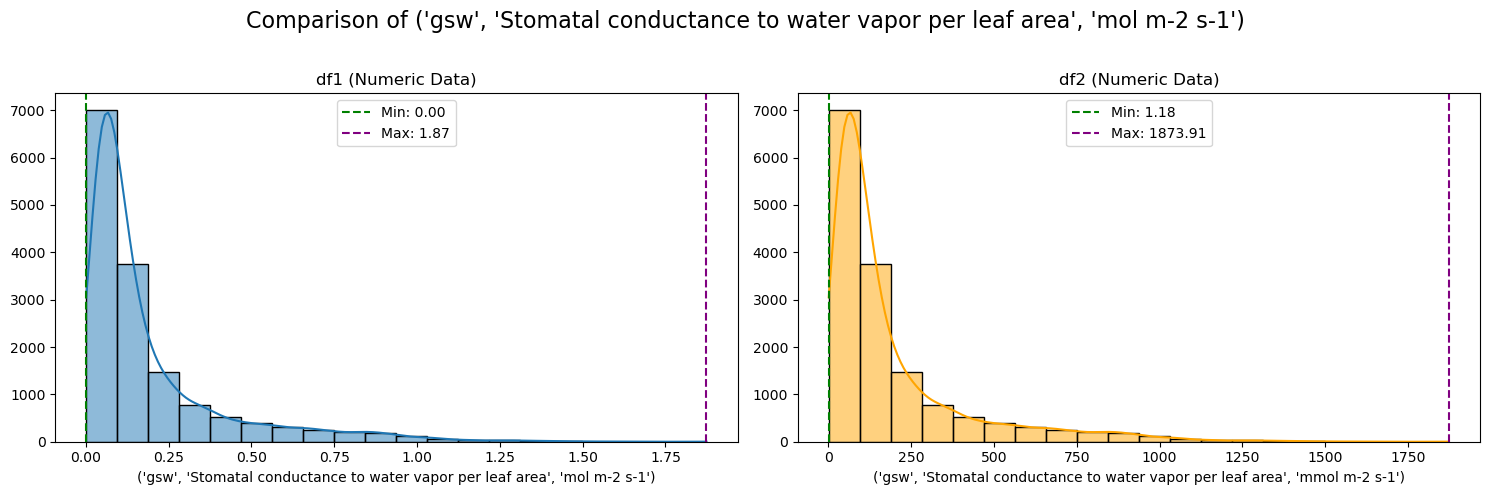

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparison(selected_col_1, selected_col_2, col_name):
    """
    Creates a subplot with one row and two columns comparing data from merged_df and filtered_df.
    - Ensures consistent bin sizes across both histograms, while allowing different x-axis ranges.
    
    Parameters:
    selected_col_1 (Series): Data for the left plot (from merged_df).
    selected_col_2 (Series): Data for the right plot (from filtered_df).
    col_name (str): The variable name being compared.
    """
    
    # Drop NaN values only for plotting
    col_1_no_nan = selected_col_1.dropna()
    col_2_no_nan = selected_col_2.dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Comparison of {col_name}', fontsize=16)
    
    # Check if the data is numeric
    if pd.api.types.is_numeric_dtype(col_1_no_nan):
        
        # Determine bin size based on the range of the first dataset
        min1, max1 = col_1_no_nan.min(), col_1_no_nan.max()
        min2, max2 = col_2_no_nan.min(), col_2_no_nan.max()
        
        # Define bin edges
        num_bins = 20
        bin_edges1 = np.linspace(min1, max1, num_bins + 1)
        bin_edges2 = np.linspace(min2, max2, num_bins + 1)

        # Plot numeric data with consistent bin sizes
        sns.histplot(col_1_no_nan, bins=bin_edges1, kde=True, ax=axes[0])
        axes[0].set_title('df1 (Numeric Data)')
        axes[0].axvline(col_1_no_nan.min(), color='green', linestyle='--', label=f'Min: {col_1_no_nan.min():.2f}')
        axes[0].axvline(col_1_no_nan.max(), color='purple', linestyle='--', label=f'Max: {col_1_no_nan.max():.2f}')
        axes[0].legend()

        sns.histplot(col_2_no_nan, bins=bin_edges2, kde=True, ax=axes[1], color='orange')
        axes[1].set_title('df2 (Numeric Data)')
        axes[1].axvline(col_2_no_nan.min(), color='green', linestyle='--', label=f'Min: {col_2_no_nan.min():.2f}')
        axes[1].axvline(col_2_no_nan.max(), color='purple', linestyle='--', label=f'Max: {col_2_no_nan.max():.2f}')
        axes[1].legend()
    
    else:
        # Plot categorical data if not numeric
        sns.countplot(y=col_1_no_nan, ax=axes[0], color='blue', legend=False)
        axes[0].set_title('df1 (Categorical Data)')
        
        sns.countplot(y=col_2_no_nan, ax=axes[1], color='orange', legend=False)
        axes[1].set_title('df2 (Categorical Data)')
    
    # Remove Y-axis labels
    axes[0].set_ylabel('')
    axes[1].set_ylabel('')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Now plot the comparison
for preconv_col, conv_col in zip(preconverted_cols, converted_cols):
    print(f'Visualizing {preconv_col} and {conv_col}')

    try:
        # Select columns using multi-level tuples
        selected_col_1 = merged_df[preconv_col].squeeze()
        selected_col_2 = merged_df_2[conv_col].squeeze()
        
        # Call the comparison plot function
        plot_comparison(selected_col_1, selected_col_2, preconv_col)

    except Exception as e:
        print(f'Could not plot...', e)

---
### 5.2. Drop out-of-range values per ESS-Dive leaf-gas-exchange info

In [54]:
oor = pd.read_csv('../data/supp/info_measured_variables.csv')
oor

,variableName,variableUnit,variableDescription,expectedValueRangeMin,expectedValueRangeMax
0,date,YYYY-MM-DD,Date of observation,NaN,NaN
1,time,HH:MM:SS,Time of observation,NaN,NaN
2,record,1,Observation record number,NaN,NaN
3,area,cm-2,Leaf area,NaN,NaN
4,A,µmol m-2 s-1,Net CO₂ exchange per leaf area,-20.0,120.0
5,Amax,µmol m-2 s-1,Highest rate of light and CO₂ saturated A,-20.0,120.0
6,Asat,µmol m-2 s-1,Highest rate of light saturated A at ambient C...,-20.0,120.0
7,Ci,µmol mol-1,Intercellular CO₂ concentration in air,0.0,5000.0
8,CO2r,µmol mol-1,CO₂ concentration in wet air entering chamber,0.0,5000.0
9,CO2s,µmol mol-1,CO₂ concentration in wet air inside chamber,0.0,5000.0


In [55]:
def filter_out_of_range_data(oor, merged_df_2):
    """
    Filters out data in merged_df_2 that falls outside the expected value range specified in oor.
    Also handles potential unit errors for specific variables (e.g., Patm in hPa vs. kPa).
    Special case for RH: Values above 100 are capped at 100 instead of being removed.
    
    Parameters:
    oor (DataFrame): Contains columns variableName, variableUnit, variableDescription, 
                     expectedValueRangeMin, expectedValueRangeMax.
    merged_df_2 (DataFrame): A DataFrame with a 3-row multi-header.
    
    Returns:
    filtered_df (DataFrame): A copy of merged_df_2 with out-of-range values removed or capped.
    filtered_columns (list): List of multi-header column names where out-of-range data was removed or capped.
    """
    
    # Create a copy of merged_df_2 to avoid modifying the original DataFrame
    filtered_df = merged_df_2.copy()

    # List to store multi-header column names where out-of-range data was removed or capped
    filtered_columns = []

    # Iterate over each row in oor
    for _, row in oor.iterrows():
        var_name = row['variableName']
        min_val = row['expectedValueRangeMin']
        max_val = row['expectedValueRangeMax']

        # Check if var_name exists in row 0 of the multi-header
        if var_name in filtered_df.columns.get_level_values(0):
            print(f"Match found for variable: {var_name}")

            # Select the corresponding column(s) in merged_df_2
            selected_cols = filtered_df.loc[:, filtered_df.columns.get_level_values(0) == var_name]

            try:
                # Attempt to convert to numeric (forcing errors to raise exceptions)
                selected_cols = selected_cols.apply(pd.to_numeric, errors='raise')

                # Store the count of non-NaN values before filtering
                count_before = selected_cols.count().sum()

                # Special handling for Patm: Check for potential hPa values mistakenly recorded as kPa
                if var_name == 'Patm':
                    print(f"Original Patm count: {count_before}")
                    suspect_values = selected_cols[selected_cols < 10]
                    print(f"Suspect Patm values count (less than 10 kPa): {suspect_values.count().sum()}")

                    if not suspect_values.empty:
                        print(f"Suspect values detected for {var_name}. Converting from hPa to kPa...")
                        # Convert suspect values from hPa to kPa by multiplying by 10
                        selected_cols = selected_cols.where(selected_cols >= 10, selected_cols * 10)
                    print(f"Patm count after conversion: {selected_cols.count().sum()}")

                # Special case for RH: Cap values above 100 at 100
                if 'RH' in var_name:
                    over_100_count = (selected_cols > 100).sum().sum()
                    if over_100_count > 0:
                        print(f"Special case for RH: Capping {over_100_count} values over 100 at 100.")
                        selected_cols = selected_cols.where(selected_cols <= 100, 100)

                # Apply min and max filtering using .where()
                if not pd.isna(min_val):
                    selected_cols = selected_cols.where(selected_cols >= min_val)
                if not pd.isna(max_val):
                    selected_cols = selected_cols.where(selected_cols <= max_val)

                # Store the count of non-NaN values after filtering
                count_after = selected_cols.count().sum()

                print(f"{var_name} count before filtering: {count_before}, count after filtering: {count_after}")

                # Check if any data was actually removed or capped
                if count_before > count_after or ('RH' in var_name and over_100_count > 0):
                    # Assign the filtered column back to filtered_df
                    filtered_df.loc[:, filtered_df.columns.get_level_values(0) == var_name] = selected_cols

                    # Add the multi-header column names to filtered_columns list
                    filtered_columns.extend(selected_cols.columns.tolist())

            except ValueError:
                # Skip columns that cannot be converted to numeric
                print(f"Skipping non-numeric variable: {var_name}")
        else:
            print(f"No match found for variable: {var_name}, skipping.")

    return filtered_df, filtered_columns

In [56]:
filtered_df, oor_cols = filter_out_of_range_data(oor, merged_df_2)
filtered_df

No match found for variable: date, skipping.
Match found for variable: time
Skipping non-numeric variable: time
No match found for variable: record, skipping.
No match found for variable: area, skipping.
Match found for variable: A
A count before filtering: 15162, count after filtering: 15162
No match found for variable: Amax, skipping.
No match found for variable: Asat, skipping.
Match found for variable: Ci
Ci count before filtering: 12857, count after filtering: 12853
No match found for variable: CO2r, skipping.
Match found for variable: CO2s
CO2s count before filtering: 15162, count after filtering: 15162
No match found for variable: dCO2, skipping.
No match found for variable: dH2O, skipping.
Match found for variable: E
E count before filtering: 12556, count after filtering: 12556
No match found for variable: flow, skipping.
Match found for variable: gbw
gbw count before filtering: 5702, count after filtering: 5702
Match found for variable: gsw
gsw count before filtering: 15162, c

,gbw,CO2s,Ci,gsw,measurementDevice,LAI,plantLeaf,siteIdentifier,Qin,Patm,...,year,month,day,uid,unadjudicatedName,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Boundary layer conductance to water vapor per leaf area,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Name of the instrument that collected data,"The ratio of the leaf area to the ground area, which determines plant growth and development patterns","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns",Location descriptor of where data was collected,"In-chamber photosynthetic flux density (PPFD) incident on the leaf, quanta per area",Atmospheric pressure of the air,...,Year of observation,Month of observation,Day of observation,Unique data row identifier,Full species name and subspecies if applicable,The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,mmol m-2 s-1,μmol mol-1,μmol mol-1,mmol m-2 s-1,1,m-2 m-2,1,1,μmol m-2 s-1,kPa,...,1,1,1,1,1,1,1,1,1,1
0,NaN,344.696180,NaN,64.946275,,<NA>,evergreen,le bray bordeaux france,697.747862,101.1,...,<NA>,<NA>,<NA>,alexandrebosc bosc a 1999 phd thesis_le bray ...,pinus pinaster,pinus pinaster,None,None,species,None
1,NaN,345.856981,NaN,69.680390,,<NA>,evergreen,le bray bordeaux france,534.691678,101.1,...,<NA>,<NA>,<NA>,alexandrebosc bosc a 1999 phd thesis_le bray ...,pinus pinaster,pinus pinaster,None,None,species,None
2,NaN,343.936307,NaN,79.564765,,<NA>,evergreen,le bray bordeaux france,783.273285,101.1,...,<NA>,<NA>,<NA>,alexandrebosc bosc a 1999 phd thesis_le bray ...,pinus pinaster,pinus pinaster,None,None,species,None
3,NaN,337.420426,NaN,83.737169,,<NA>,evergreen,le bray bordeaux france,872.500396,101.141723,...,<NA>,<NA>,<NA>,alexandrebosc bosc a 1999 phd thesis_le bray ...,pinus pinaster,pinus pinaster,None,None,species,None
4,NaN,344.366214,NaN,78.168506,,<NA>,evergreen,le bray bordeaux france,574.455977,101.2,...,<NA>,<NA>,<NA>,alexandrebosc bosc a 1999 phd thesis_le bray ...,pinus pinaster,pinus pinaster,None,None,species,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15157,2840.0,364.650000,277.000000,82.050000,licor 6400,<NA>,deciduous,hakkoda aomori japan,2001.0,92.165,...,<NA>,<NA>,<NA>,yusuke onoda yasumura et al. 2005 & onoda unpu...,magnolia salicifolia,magnolia salicifolia,None,None,species,None
15158,2840.0,367.300000,274.000000,126.500000,licor 6400,<NA>,deciduous,hakkoda aomori japan,2000.5,92.155,...,<NA>,<NA>,<NA>,yusuke onoda yasumura et al. 2005 & onoda unpu...,magnolia salicifolia,magnolia salicifolia,None,None,species,None


Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


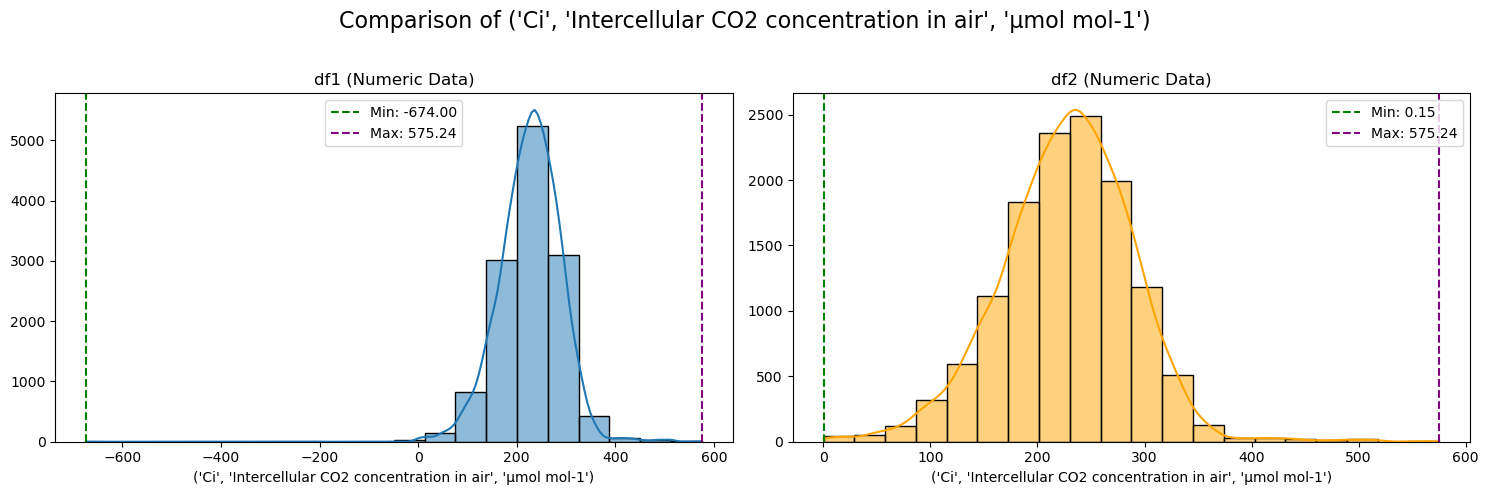

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


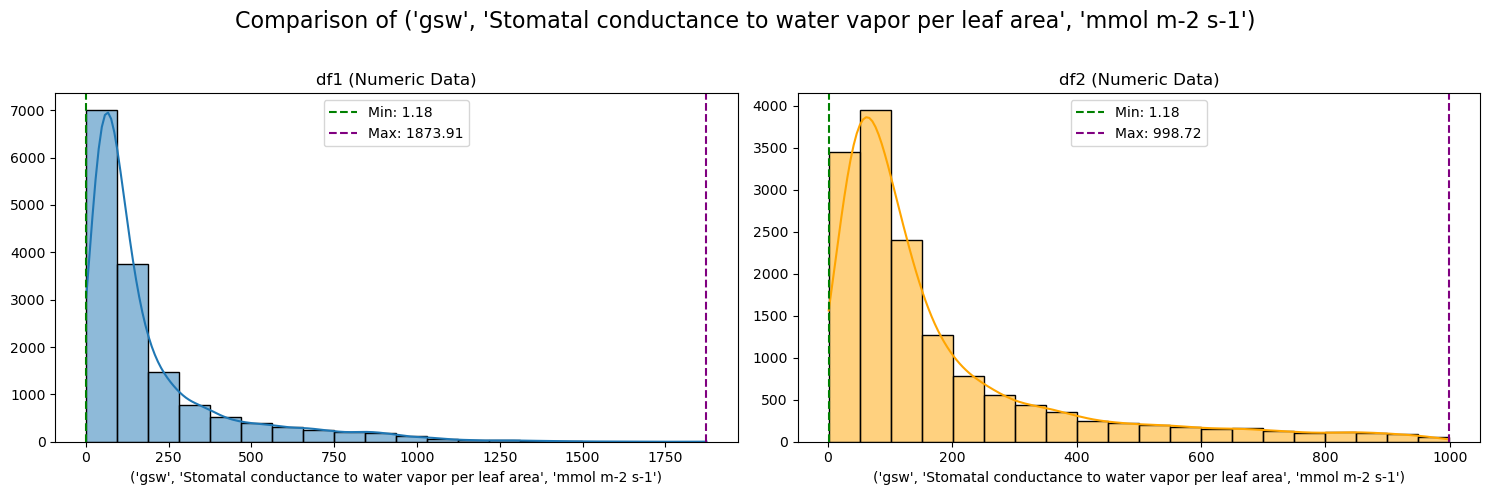

Visualizing ('Patm', 'Atmospheric pressure of the air', 'kPa')


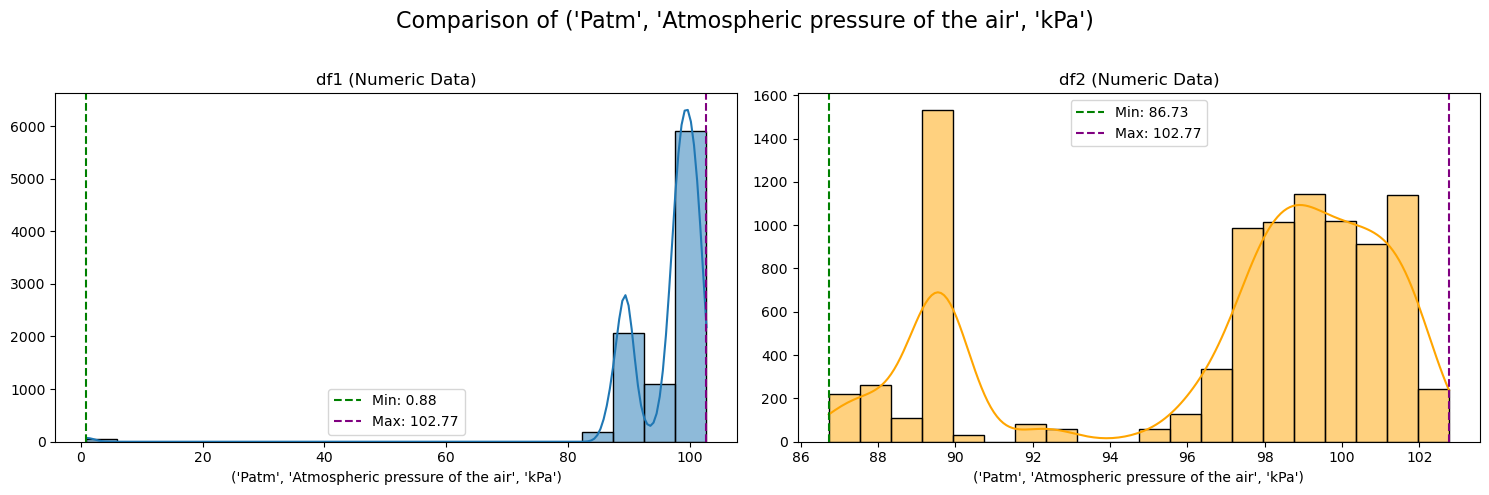

Visualizing ('Qin', 'In-chamber photosynthetic flux density (PPFD) incident on the leaf, quanta per area', 'μmol m-2 s-1')


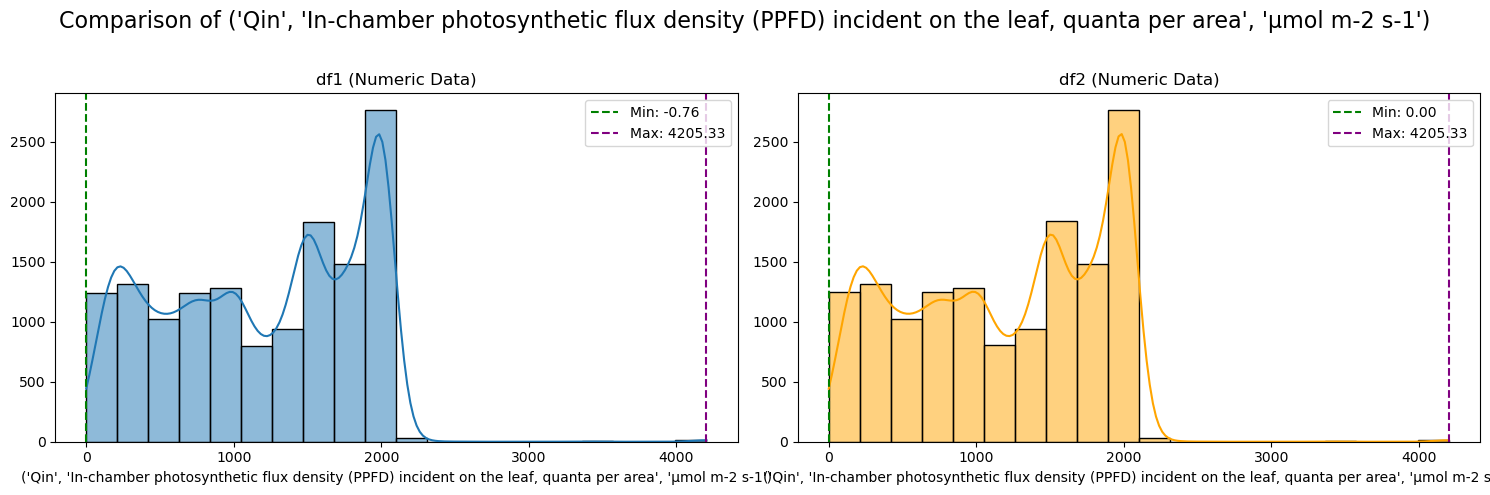

Visualizing ('RHs', 'Relative humidity of air inside the chamber', '%')


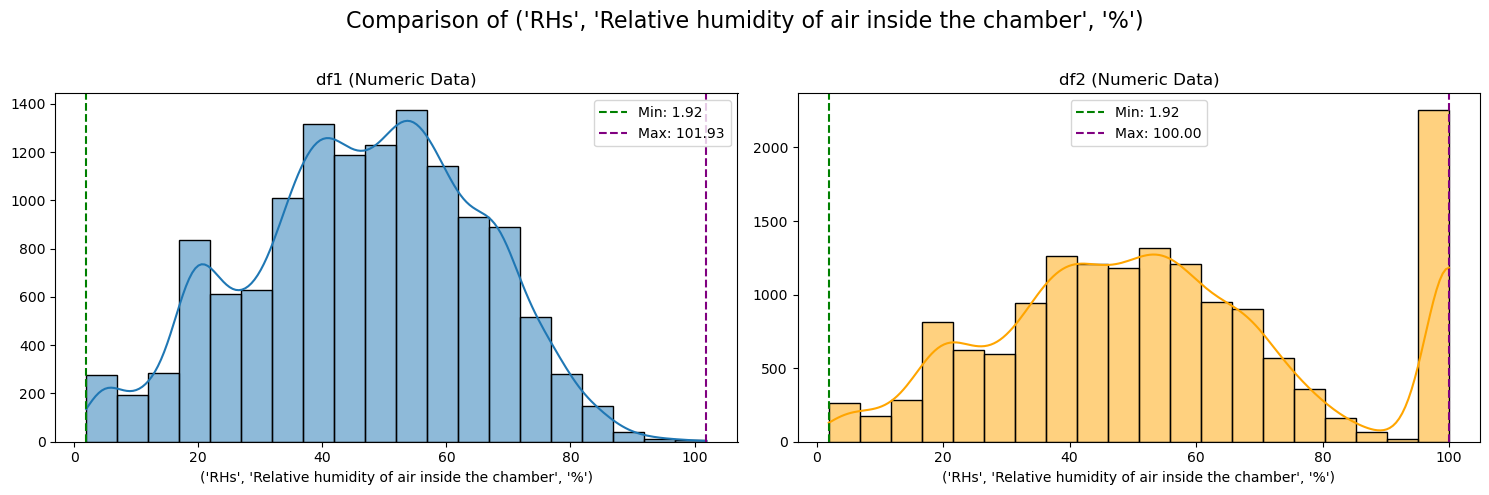

Visualizing ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa')


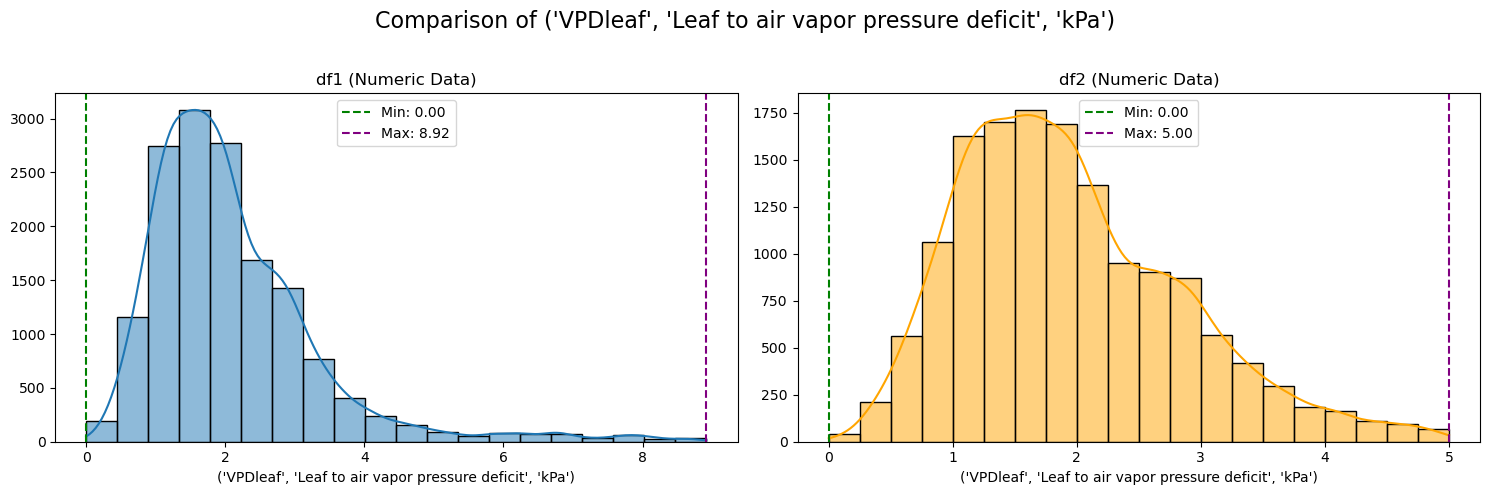

In [116]:
# Now plot the comparison
for oor_col in oor_cols:
    print(f'Visualizing {oor_col}')

    try:
        # Select columns using multi-level tuples
        selected_col_1 = merged_df_2[oor_col].squeeze()
        selected_col_2 = filtered_df[oor_col].squeeze()
        
        # Call the comparison plot function
        plot_comparison(selected_col_1, selected_col_2, oor_col)

    except Exception as e:
        print(f'Could not plot...', e)

In [57]:
# export
filtered_df.to_csv(f'../data/output/{filename}.csv', encoding='utf-8-sig')

In [58]:
# Create the profiling report
df = filtered_df.copy()
df.columns = df.columns.get_level_values(0)
profile = ProfileReport(df, title=f"{filename} Quality Controlled Profiling Report")

# Save the profile report as HTML
output_directory = f'../data/input/{filename}'
report_html_path = os.path.join(output_directory, f"{filename}_qc_report.html")
profile.to_file(report_html_path)
print(f"Profiling report saved as {report_html_path}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling report saved as ../data/input/lin_2015/lin_2015_qc_report.html
